In [450]:
# remotes::install_github(repo="phillipbvetter/ctsmTMB", dependencies=TRUE)

# 2.1

In [451]:
plot_ctsm_fits <- function(model, data, 
                           response = "stormwater",
                           time_var = "t"
                          ) {
  
  pred <- model$predict(data = data)

  obs <- pred$observations

  df <- data.frame(
    time      = obs$t.j,              
    observed  = obs$stormwater.data,
    fitted    = obs$stormwater  
  )

  ggplot(df, aes(x = time)) +
    geom_point(aes(y = observed, colour = "Observed"), size = 1) +
    geom_line(aes(y = fitted, colour = "Fitted"), linewidth = 0.8) +
    labs(y = "Stormwater", colour = "") +
    theme_minimal()
}

# plot_ctsm_fits(model, data,
#                response = "stormwater",
#                time_var = "t")


In [452]:
library(TMB)
library(ctsmTMB)
library(ggplot2)

In [453]:
ex1_overflow = read.csv("data/ex1_rainfallrunoff.csv")
head(ex1_overflow)

timestamp           rainfall stormwater
1 2024-04-01 08:00:00 0.003    0         
2 2024-04-01 08:01:00 0.000    0         
3 2024-04-01 08:02:00 0.000    0         
4 2024-04-01 08:03:00 0.000    0         
5 2024-04-01 08:04:00 0.000    0         
6 2024-04-01 08:05:00 0.000    0

In [454]:
# Convert timestamps to numeric time (hours since first observation)
ex1_overflow$t <- as.numeric(
  difftime(as.POSIXct(ex1_overflow$timestamp),
           as.POSIXct(ex1_overflow$timestamp[1]),
           units = "hours")
)

head(ex1_overflow)

timestamp           rainfall stormwater t         
1 2024-04-01 08:00:00 0.003    0          0.00000000
2 2024-04-01 08:01:00 0.000    0          0.01666667
3 2024-04-01 08:02:00 0.000    0          0.03333333
4 2024-04-01 08:03:00 0.000    0          0.05000000
5 2024-04-01 08:04:00 0.000    0          0.06666667
6 2024-04-01 08:05:00 0.000    0          0.08333333

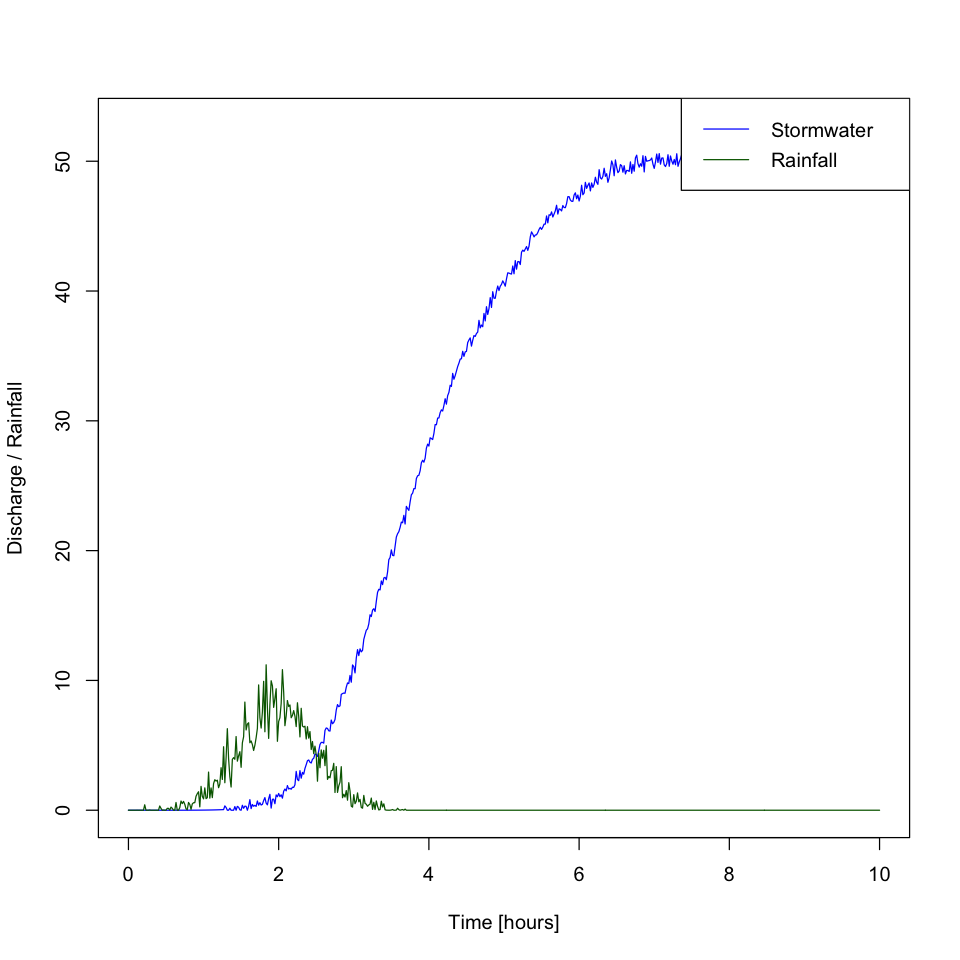

In [455]:
# Plot rainfall and stormwater for ex2_overflow
plot(ex1_overflow$t, ex1_overflow$stormwater, type = "l", col = "blue",
     xlab = "Time [hours]", ylab = "Discharge / Rainfall")

lines(ex1_overflow$t, ex1_overflow$rainfall, col = "darkgreen")

legend("topright", legend = c("Stormwater", "Rainfall"),
       col = c("blue", "darkgreen"), lty = 1)


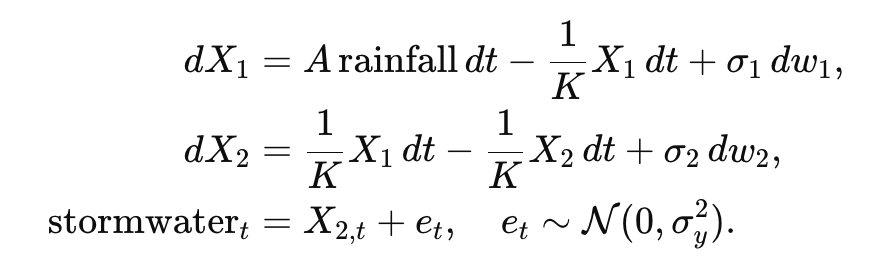

sigma1=sigma2=sigmax

In [456]:
# m <- ctsmTMB$new()

# m$addSystem(
#   dX1 ~ A * rainfall * dt - (1/K) * X1 * dt + sigma_1 * dw1,
#   dX2 ~ (1/K) * X1 * dt + sigma_2 * dw2
# )
# m$addObs(stormwater ~ X2)
# m$setVariance(stormwater ~ sigma_y^2)
# m$addInput(rainfall)

# m$setParameter(
#   A      = c(initial = 1,   lower = 1e-6, upper = 1e3),
#   K      = c(initial = 10,  lower = 1e-6, upper = 1e4),
#   sigma_1 = c(initial = 0.1, lower = 1e-8, upper = 10),
#   sigma_2 = c(initial = 0.1, lower = 1e-8, upper = 10),
#   sigma_y= c(initial = 0.1, lower = 1e-8, upper = 10)
# )

# # Proper initial state specification (mean + covariance)
# m$setInitialState(list(
#   x0 = c(X1 = 0, X2 = 0),
#   p0 = diag(2) * 0.01
# ))

# fit <- m$estimate(data = ex1_overflow)

# summary(fit)

# loglik_val <- fit$getLikelihood
# cat("\nLogLik:", loglik_val, "\n")

# cat("K:", fit$par["K"], "  A:", fit$par["A"], "\n")

In [457]:
# This model only considers one same variance for both states (reservoirs)

m <- ctsmTMB$new()

m$addSystem(
  dX1 ~ A * rainfall * dt - (1/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (1/K) * X1 * dt + sigma_x * dw2
)
m$addObs(stormwater ~ X2)
m$setVariance(stormwater ~ sigma_y^2)
m$addInput(rainfall)

m$setParameter(
  A      = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K      = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y= c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0),
  p0 = diag(2) * 0.01
))

fit <- m$estimate(data = ex1_overflow)

summary(fit)

loglik_val <- fit$getLikelihood
cat("\nLogLik:", loglik_val, "\n")

cat("K:", fit$par["K"], "  A:", fit$par["A"], "\n")
-fit$nll

Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     26737.642:  1.00000  10.0000 0.100000 0.100000
 10:     230.50642:  8.40884  5.09717  1.32316 0.258392
 20:     217.62683:  6.24496  2.98180  1.08238 0.268672


	 Optimization finished!:
            Elapsed time: 0.047 seconds.
            The objective value is: 2.176268e+02
            The maximum gradient component is: 3.7e-04
            The convergence message is: relative convergence (4)
            Iterations: 22
            Evaluations: Fun: 32 Grad: 23
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
        Estimate Std. Error t value  Pr(>|t|)    
A       6.244946   0.465387  13.419 < 2.2e-16 ***
K       2.981866   0.289410  10.303 < 2.2e-16 ***
sigma_x 1.082413   0.077299  14.003 < 2.2e-16 ***
sigma_y 0.268672   0.009737  27.593 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik: 
K: 2.981866   A: 6.244946 


[1] -217.6268

In [458]:
p <- m$predict(data = ex1_overflow)
p

Checking and setting data...

Predicting with R...

Returning results...

Finished!



$states
    i.  j. t.i         t.j k.ahead           X1           X2     var.X1
1    0   0   0  0.00000000       0 0.000000e+00 0.000000e+00 0.01000000
2    0   1   0  0.01666667       1 1.555431e-04 5.805351e-07 0.02930707
3    0   2   0  0.03333333       2 1.546762e-04 1.447493e-06 0.04839951
4    0   3   0  0.05000000       3 1.538140e-04 2.309620e-06 0.06727972
5    0   4   0  0.06666667       4 1.529567e-04 3.166940e-06 0.08595004
6    0   5   0  0.08333333       5 1.521042e-04 4.019483e-06 0.10441282
7    0   6   0  0.10000000       6 1.512564e-04 4.867273e-06 0.12267036
8    0   7   0  0.11666667       7 3.581909e-04 6.097631e-06 0.14072493
9    0   8   0  0.13333333       8 5.635852e-04 8.868144e-06 0.15857881
10   0   9   0  0.15000000       9 6.643327e-04 1.220307e-05 0.17623421
11   0  10   0  0.16666667      10 7.643253e-04 1.629292e-05 0.19369335
12   0  11   0  0.18333333      11 7.600651e-04 2.055308e-05 0.21095841
13   0  12   0  0.20000000      12 7.558287e-04 2.478949e-05 0.22803154
14   0  13   0  0.21666667      13 2.251632e-02 6.957122e-05 0.24491487
15   0  14   0  0.23333333      14 4.411500e-02 2.761529e-04 0.26161053
16   0  15   0  0.25000000      15 4.386912e-02 5.220389e-04 0.27812059
17   0  16   0  0.26666667      16 4.362460e-02 7.665544e-04 0.29444711
18   0  17   0  0.28333333      17 4.436839e-02 1.011547e-03 0.31059215
19   0  18   0  0.30000000      18 4.510620e-02 1.262522e-03 0.32655770
20   0  19   0  0.31666667      19 4.485479e-02 1.513932e-03 0.34234578
21   0  20   0  0.33333333      20 4.460478e-02 1.763942e-03 0.35795835
22   0  21   0  0.35000000      21 4.435617e-02 2.012558e-03 0.37339737
23   0  22   0  0.36666667      22 4.410894e-02 2.259788e-03 0.38866475
24   0  23   0  0.38333333      23 4.386308e-02 2.505640e-03 0.40376242
25   0  24   0  0.40000000      24 4.361860e-02 2.750122e-03 0.41869226
26   0  25   0  0.41666667      25 6.030935e-02 3.024805e-03 0.43345613
27   0  26   0  0.43333333      26 8.435555e-02 3.437982e-03 0.44805588
28   0  27   0  0.45000000      27 9.135144e-02 3.936024e-03 0.46249333
29   0  28   0  0.46666667      28 9.146560e-02 4.446356e-03 0.47677029
30   0  29   0  0.48333333      29 9.162991e-02 4.958581e-03 0.49088854
31   0  30   0  0.50000000      30 9.132687e-02 5.469788e-03 0.50484984
32   0  31   0  0.51666667      31 9.845338e-02 5.993344e-03 0.51865595
33   0  32   0  0.53333333      32 1.128507e-01 6.583906e-03 0.53230858
34   0  33   0  0.55000000      33 1.201552e-01 7.241645e-03 0.54580944
35   0  34   0  0.56666667      34 1.324188e-01 7.936339e-03 0.55916022
36   0  35   0  0.58333333      35 1.516561e-01 8.734891e-03 0.57236259
37   0  36   0  0.60000000      36 1.583807e-01 9.608340e-03 0.58541819
38   0  37   0  0.61666667      37 1.575498e-01 1.049131e-02 0.59832867
39   0  38   0  0.63333333      38 1.876824e-01 1.142725e-02 0.61109562
40   0  39   0  0.65000000      39 2.176933e-01 1.258907e-02 0.62372065
41   0  40   0  0.66666667      40 2.166356e-01 1.380292e-02 0.63620534
42   0  41   0  0.68333333      41 2.258169e-01 1.502986e-02 0.64855124
43   0  42   0  0.70000000      42 2.716526e-01 1.639556e-02 0.66075990
44   0  43   0  0.71666667      43 3.333902e-01 1.809617e-02 0.67283284
45   0  44   0  0.73333333      44 3.932444e-01 2.011893e-02 0.68477157
46   0  45   0  0.75000000      45 4.499959e-01 2.248632e-02 0.69657759
47   0  46   0  0.76666667      46 4.767920e-01 2.509348e-02 0.70825237
48   0  47   0  0.78333333      47 4.816561e-01 2.777538e-02 0.71979736
49   0  48   0  0.80000000      48 5.120044e-01 3.052526e-02 0.73121402
50   0  49   0  0.81666667      49 5.633747e-01 3.353805e-02 0.74250376
51   0  50   0  0.83333333      50 5.869427e-01 3.677124e-02 0.75366800
52   0  51   0  0.85000000      51 6.123899e-01 4.010283e-02 0.76470814
53   0  52   0  0.86666667      52 6.641466e-01 4.366596e-02 0.77562555
54   0  53   0  0.88333333      53 7.206444e-01 4.753594e-02 0.78642159
55   0  54   0  0.90000000      

Checking and setting data...

Predicting with R...

Returning results...

Finished!



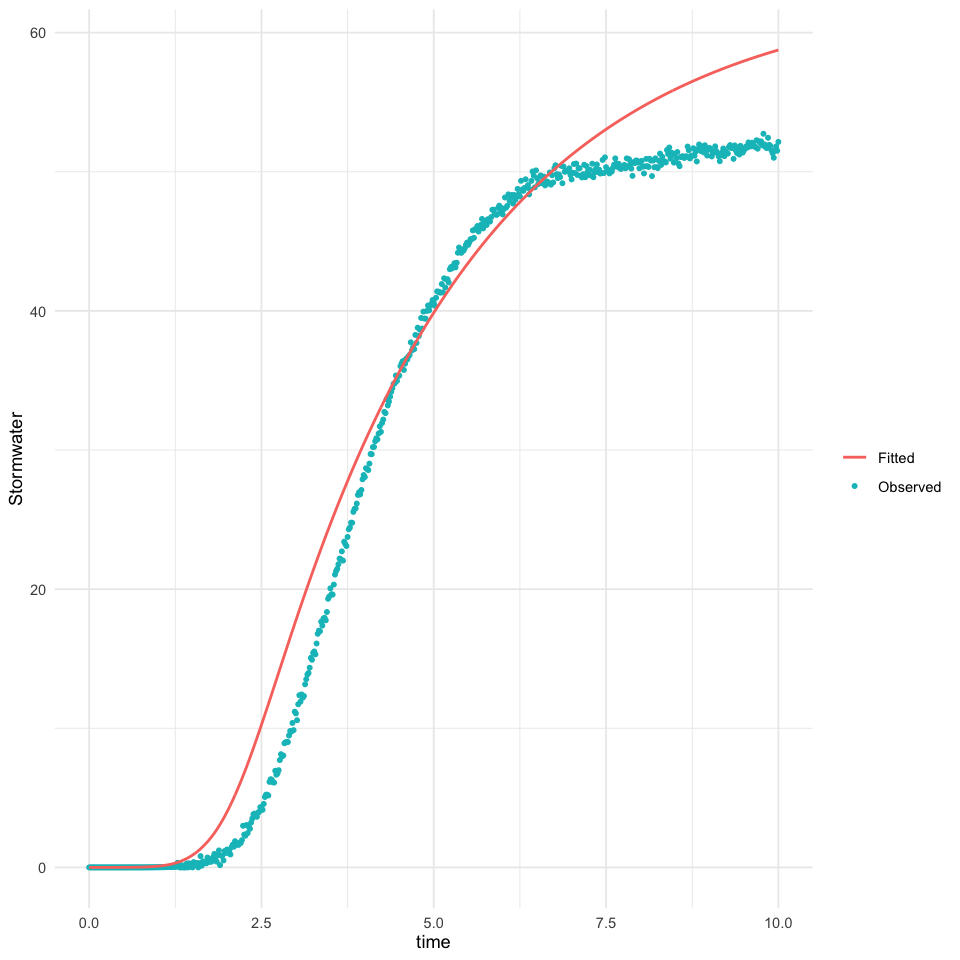

In [459]:
plot_ctsm_fits(m, ex1_overflow,
               response = "stormwater",
               time_var = "t")


agg_record_1175770201 
                    2

agg_record_1175770201 
                    2

[[1]]



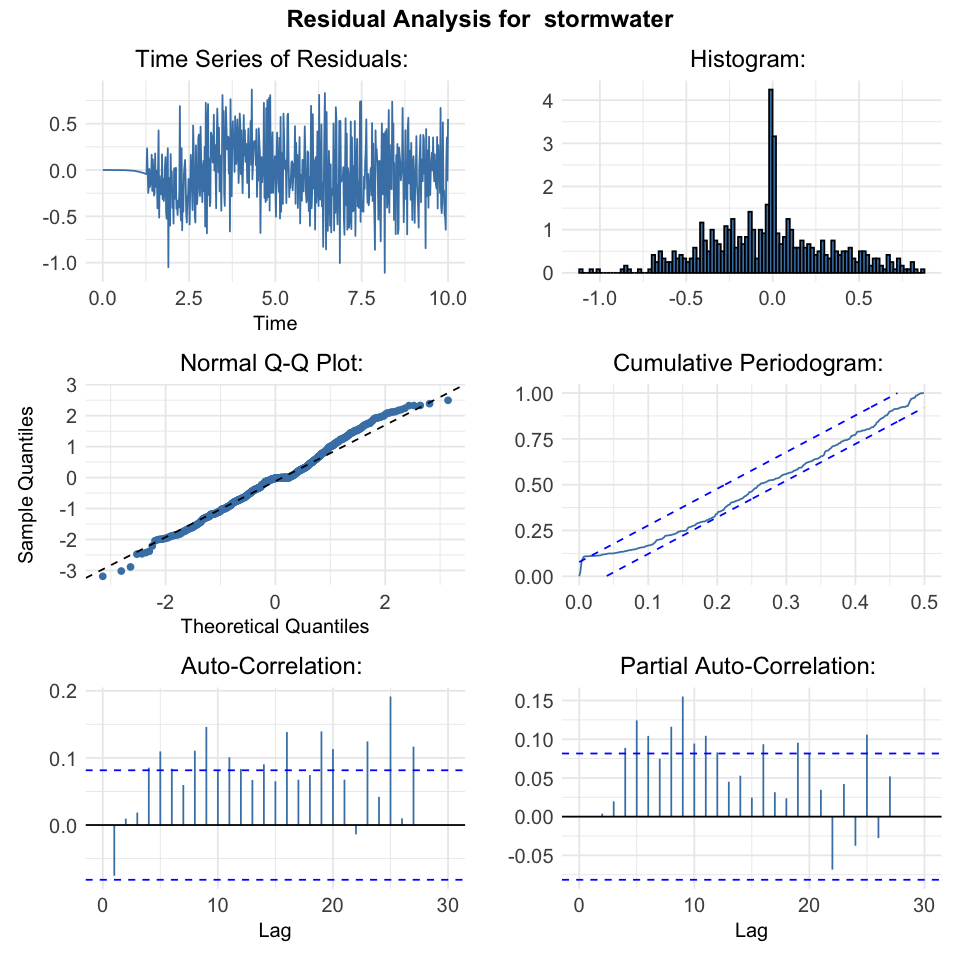

In [460]:
p = plot(fit)
dev.off()
dev.set(2) # check which device vscode is using
print(p)

## 2.1.2

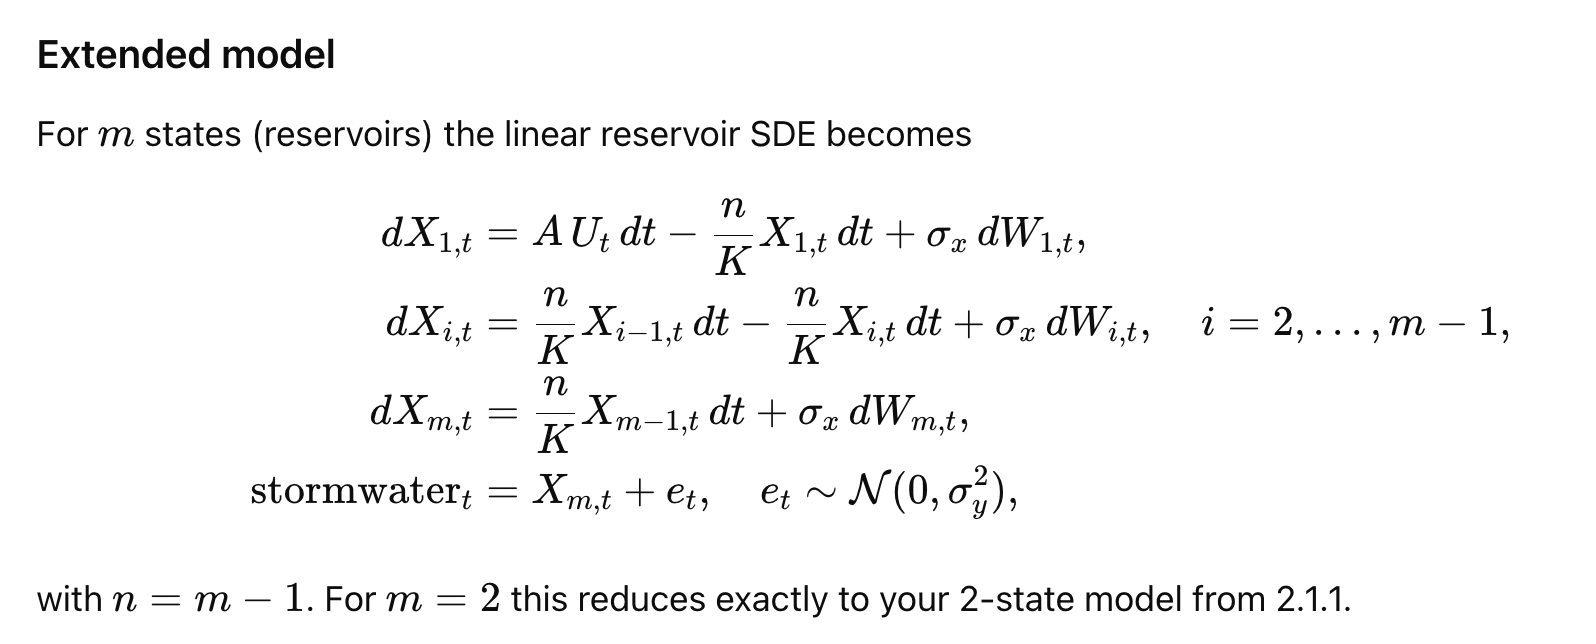

In [461]:
dat <- ex1_overflow

param_setup <- function(mdl) {
  mdl$setParameter(
    A       = c(initial = 1,   lower = 1e-6, upper = 1e3),
    K       = c(initial = 3,   lower = 1e-6, upper = 1e4),
    sigma_x = c(initial = 0.5, lower = 1e-8, upper = 10),
    sigma_y = c(initial = 0.2, lower = 1e-8, upper = 10)
  )
}

init_state <- function(mdl, n) {
  m  <- n + 1                      # number of reservoirs/states
  x0 <- setNames(rep(0, m), paste0("X", 1:m))
  p0 <- diag(m) * 0.01
  mdl$setInitialState(list(x0 = x0, p0 = p0))
}

info <- function(fit, n) {
  ll  <- fit$getLikelihood
  k   <- length(fit$par)
  AIC <- -2 * ll + 2 * k
  BIC <- -2 * ll + log(nrow(dat)) * k
  data.frame(n = n, states = n + 1, logLik = ll, k = k, AIC = AIC, BIC = BIC)
}

In [462]:
m <- ctsmTMB$new()

m$addSystem(
  dX1 ~ A * rainfall * dt - (1/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (1/K) * X1 * dt + sigma_x * dw2
)
m$addObs(stormwater ~ X2)
m$setVariance(stormwater ~ sigma_y^2)
m$addInput(rainfall)

m$setParameter(
  A      = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K      = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y= c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0),
  p0 = diag(2) * 0.01
))

fit <- m$estimate(data = ex1_overflow)

summary(fit)

loglik_val <- fit$getLikelihood
cat("\nLogLik:", loglik_val, "\n")

cat("K:", fit$par["K"], "  A:", fit$par["A"], "\n")

Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     26737.642:  1.00000  10.0000 0.100000 0.100000
 10:     230.50642:  8.40884  5.09717  1.32316 0.258392
 20:     217.62683:  6.24496  2.98180  1.08238 0.268672


	 Optimization finished!:
            Elapsed time: 0.033 seconds.
            The objective value is: 2.176268e+02
            The maximum gradient component is: 3.7e-04
            The convergence message is: relative convergence (4)
            Iterations: 22
            Evaluations: Fun: 32 Grad: 23
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
        Estimate Std. Error t value  Pr(>|t|)    
A       6.244946   0.465387  13.419 < 2.2e-16 ***
K       2.981866   0.289410  10.303 < 2.2e-16 ***
sigma_x 1.082413   0.077299  14.003 < 2.2e-16 ***
sigma_y 0.268672   0.009737  27.593 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik: 
K: 2.981866   A: 6.244946 


In [463]:
# 2 states

m2 <- ctsmTMB$new()

m2$addSystem(
  dX1 ~ A * rainfall * dt - (2/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (2/K) * X1 * dt - (2/K) * X2 * dt + sigma_x * dw2,
  dX3 ~ (2/K) * X2 * dt + sigma_x * dw3
)
m2$addObs(stormwater ~ X3)
m2$setVariance(stormwater ~ sigma_y^2)
m2$addInput(rainfall)

m2$setParameter(
  A      = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K      = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y= c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m2$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0, X3 = 0),
  p0 = diag(3) * 0.01
))

fit2 <- m2$estimate(data = ex1_overflow)

summary(fit2)

loglik_val <- fit2$getLikelihood
cat("\nLogLik:", loglik_val, "\n")

cat("K:", fit2$par["K"], "  A:", fit2$par["A"], "\n")

Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     24631.205:  1.00000  10.0000 0.100000 0.100000
 10:     231.27542:  7.27193  3.65059  1.60204 0.256526
 20:     168.94550:  5.54335  2.18754 0.595064 0.286266


	 Optimization finished!:
            Elapsed time: 0.069 seconds.
            The objective value is: 1.676739e+02
            The maximum gradient component is: 4.8e-05
            The convergence message is: relative convergence (4)
            Iterations: 28
            Evaluations: Fun: 47 Grad: 29
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.6120889  0.2020983 27.7691 < 2.2e-16 ***
K       2.2503999  0.0741927 30.3318 < 2.2e-16 ***
sigma_x 0.5180620  0.0547357  9.4648 < 2.2e-16 ***
sigma_y 0.2834951  0.0090276 31.4030 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik: 
K: 2.2504   A: 5.612089 


In [464]:
# 3 states (n = 3 → 4 reservoirs: X1, X2, X3, X4)

m3 <- ctsmTMB$new()

m3$addSystem(
  dX1 ~ A * rainfall * dt - (3/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (3/K) * X1 * dt - (3/K) * X2 * dt + sigma_x * dw2,
  dX3 ~ (3/K) * X2 * dt - (3/K) * X3 * dt + sigma_x * dw3,
  dX4 ~ (3/K) * X3 * dt                 + sigma_x * dw4
)
m3$addObs(stormwater ~ X4)
m3$setVariance(stormwater ~ sigma_y^2)
m3$addInput(rainfall)

m3$setParameter(
  A       = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K       = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m3$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0, X3 = 0, X4 = 0),
  p0 = diag(4) * 0.01
))

fit3 <- m3$estimate(data = ex1_overflow)

summary(fit3)

loglik_val3 <- fit3$getLikelihood
cat("\nLogLik (n=3):", loglik_val3, "\n")
cat("K:", fit3$par["K"], "  A:", fit3$par["A"], "\n")


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     22223.641:  1.00000  10.0000 0.100000 0.100000
 10:     223.34193:  3.95384  2.42757  1.59676 0.251596
 20:     151.86994:  5.15731  2.03352 0.278894 0.292756


	 Optimization finished!:
            Elapsed time: 0.172 seconds.
            The objective value is: 1.508462e+02
            The maximum gradient component is: 4.9e-05
            The convergence message is: relative convergence (4)
            Iterations: 29
            Evaluations: Fun: 47 Grad: 30
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.0578408  0.1100501  45.959 < 2.2e-16 ***
K       2.0560482  0.0365468  56.258 < 2.2e-16 ***
sigma_x 0.2769054  0.0492540   5.622 2.901e-08 ***
sigma_y 0.2908643  0.0090439  32.161 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik (n=3): 
K: 2.056048   A: 5.057841 


Checking and setting data...

Predicting with R...

Returning results...

Finished!



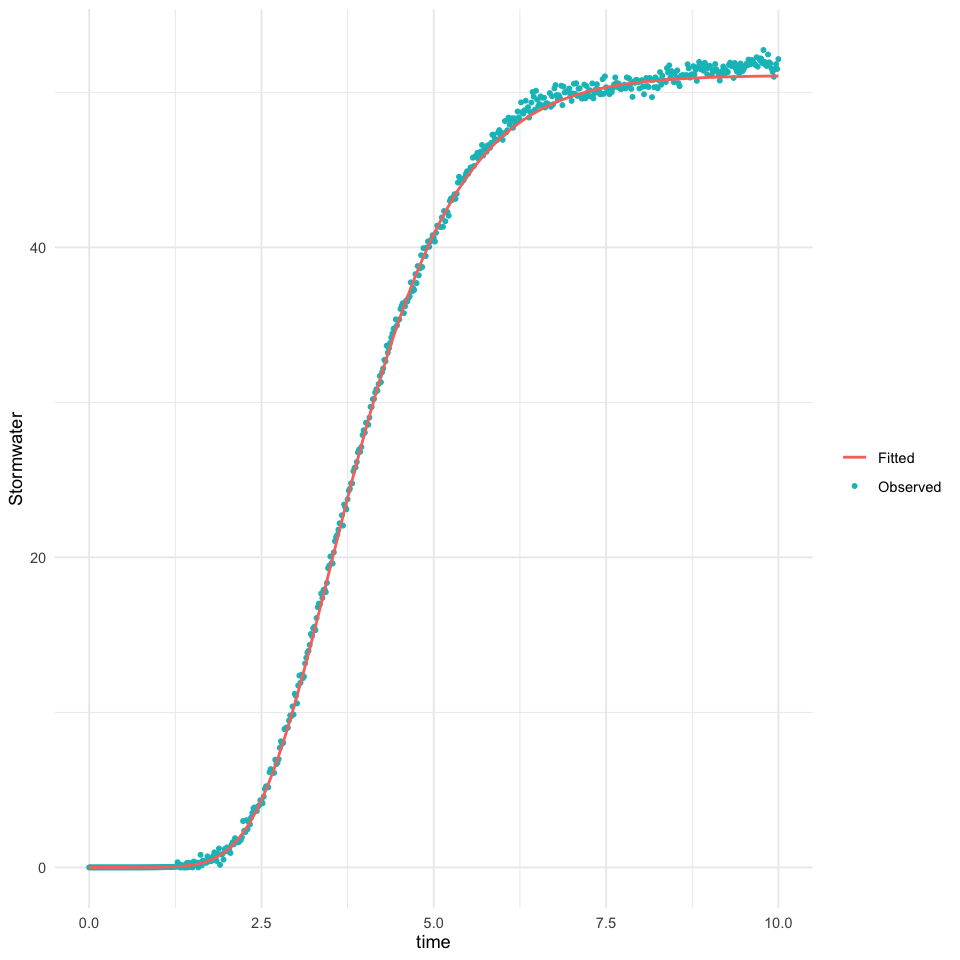

In [466]:
plot_ctsm_fits(m3, ex1_overflow,
               response = "stormwater",
               time_var = "t")

In [ ]:
# 5 states (n = 5 → 6 reservoirs: X1, X2, X3, X4, X5, X6)

m5 <- ctsmTMB$new()

m5$addSystem(
  dX1 ~ A * rainfall * dt - (5/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (5/K) * X1 * dt - (5/K) * X2 * dt + sigma_x * dw2,
  dX3 ~ (5/K) * X2 * dt - (5/K) * X3 * dt + sigma_x * dw3,
  dX4 ~ (5/K) * X3 * dt - (5/K) * X4 * dt + sigma_x * dw4,
  dX5 ~ (5/K) * X4 * dt - (5/K) * X5 * dt + sigma_x * dw5,
  dX6 ~ (5/K) * X5 * dt                 + sigma_x * dw6
)
m5$addObs(stormwater ~ X6)
m5$setVariance(stormwater ~ sigma_y^2)
m5$addInput(rainfall)

m5$setParameter(
  A       = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K       = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m5$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0, X3 = 0, X4 = 0, X5 = 0, X6 = 0),
  p0 = diag(6) * 0.01
))

fit5 <- m5$estimate(data = ex1_overflow)

summary(fit5)

loglik_val5 <- fit5$getLikelihood
cat("\nLogLik (n=5):", loglik_val5, "\n")
cat("K:", fit5$par["K"], "  A:", fit5$par["A"], "\n")


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     17816.960:  1.00000  10.0000 0.100000 0.100000
 10:     235.85554:  2.67762  3.52637  1.48929 0.253659
 20:     168.44222:  4.37121  1.90511 0.462863 0.284948


	 Optimization finished!:
            Elapsed time: 0.177 seconds.
            The objective value is: 1.684285e+02
            The maximum gradient component is: 1.5e-05
            The convergence message is: relative convergence (4)
            Iterations: 27
            Evaluations: Fun: 41 Grad: 28
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       4.3405646  0.1974690  21.981 < 2.2e-16 ***
K       1.9001177  0.0650344  29.217 < 2.2e-16 ***
sigma_x 0.4651222  0.0519227   8.958 < 2.2e-16 ***
sigma_y 0.2848226  0.0089896  31.683 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik (n=5): 
K: 1.900118   A: 4.340565 


In [ ]:
# 6 states (n = 6 → 7 reservoirs: X1, X2, X3, X4, X5, X6, X7)

m6 <- ctsmTMB$new()

m6$addSystem(
  dX1 ~ A * rainfall * dt - (6/K) * X1 * dt + sigma_x * dw1,
  dX2 ~ (6/K) * X1 * dt - (6/K) * X2 * dt + sigma_x * dw2,
  dX3 ~ (6/K) * X2 * dt - (6/K) * X3 * dt + sigma_x * dw3,
  dX4 ~ (6/K) * X3 * dt - (6/K) * X4 * dt + sigma_x * dw4,
  dX5 ~ (6/K) * X4 * dt - (6/K) * X5 * dt + sigma_x * dw5,
  dX6 ~ (6/K) * X5 * dt - (6/K) * X6 * dt + sigma_x * dw6,
  dX7 ~ (6/K) * X6 * dt                 + sigma_x * dw7
)
m6$addObs(stormwater ~ X7)
m6$setVariance(stormwater ~ sigma_y^2)
m6$addInput(rainfall)

m6$setParameter(
  A       = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K       = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Proper initial state specification (mean + covariance)
m6$setInitialState(list(
  x0 = c(X1 = 0, X2 = 0, X3 = 0, X4 = 0, X5 = 0, X6 = 0, X7 = 0),
  p0 = diag(7) * 0.01
))

fit6 <- m6$estimate(data = ex1_overflow)

summary(fit6)

loglik_val6 <- fit6$getLikelihood
cat("\nLogLik (n=6):", loglik_val6, "\n")
cat("K:", fit6$par["K"], "  A:", fit6$par["A"], "\n")


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     16003.410:  1.00000  10.0000 0.100000 0.100000
 10:     234.65092: 0.785051  2.86413  1.42719 0.260315
 20:     173.91726:  4.36759  1.87436 0.523437 0.285828


	 Optimization finished!:
            Elapsed time: 0.263 seconds.
            The objective value is: 1.731686e+02
            The maximum gradient component is: 8.6e-05
            The convergence message is: relative convergence (4)
            Iterations: 28
            Evaluations: Fun: 48 Grad: 29
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       4.1160452  0.2192206 18.7758 < 2.2e-16 ***
K       1.8613963  0.0733743 25.3685 < 2.2e-16 ***
sigma_x 0.4981073  0.0528028  9.4334 < 2.2e-16 ***
sigma_y 0.2839308  0.0090026 31.5388 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LogLik (n=6): 
K: 1.861396   A: 4.116045 


In [ ]:
# negative log likelihood
-f$nll

[1] -167.6739

In [ ]:
models <- list(
  n1 = fit,   # rename if needed
  n2 = fit2,
  n3 = fit3,
  n4 = fit4,
  n5 = fit5,
  n6 = fit6
)

# ---- Data used in fitting ----
n_obs <- nrow(ex1_overflow)

# ---- Function to extract metrics for one model ----
extract_ic <- function(fit, n) {
  
  # log-likelihood
  ll <- -fit$nll
  
  # number of free parameters
  k <- length(fit$par)
  
  # AIC & BIC
  AIC_val <- -2 * ll + 2 * k
  BIC_val <- -2 * ll + log(n_obs) * k
  
  data.frame(
    states = n,
    logLik = ll,
    # k      = k,
    AIC    = AIC_val,
    BIC    = BIC_val
  )
}

# ---- Loop over models and bind results ----
results <- do.call(
  rbind,
  lapply(seq_along(models), function(i) {
    extract_ic(models[[i]], n = i)
  })
)

# ---- Print nicely ----
print(results)


  states    logLik      AIC      BIC
1      1 -217.6268 443.2537 460.8480
2      2 -167.6739 343.3479 360.9423
3      3 -150.8462 309.6923 327.2867
4      4 -160.8798 329.7596 347.3540
5      5 -168.4285 344.8570 362.4514
6      6 -173.1686 354.3372 371.9316


### Model Selection for the Extended Linear Reservoir (Task 2.1.2)

We estimated linear reservoir cascade models with 1–6 states (i.e., 1–6 storage layers feeding each other) and compared them using likelihood-based information criteria. Importantly, all models estimated the same four parameters \((A, K, \sigma_x, \sigma_y)\); adding states increases system dimensionality but does **not** increase the number of estimated parameters. This means that AIC/BIC differences come entirely from improvements in the log-likelihood, not from added parameter penalty.

The log-likelihood improved substantially when increasing the number of states from 1 → 2 → 3, and the AIC decreased correspondingly, reaching its minimum at **3 states**, indicating that this model provides the best fit within the tested range. Beyond 3 states, the likelihood began to deteriorate and AIC/BIC both increased, suggesting that additional states do not improve explanatory power and instead introduce unnecessary system complexity. Thus, based on both AIC and BIC, the **3-state linear reservoir** is the most suitable model for this dataset.

Overall, the model selection analysis shows that while increasing the number of reservoirs initially improves the fit, the benefit peaks at three states. Additional reservoirs do not meaningfully improve model performance and are penalized by information criteria, confirming that **a 3-state model provides the optimal balance between parsimony and predictive accuracy**.


## 2.1.3

The model with best fit, selected by the having both lowest AIC and BIC, was the model cmprised of 3 states. The reported parameters are $K=2.06$ and $A=5.06$. In contrast, the two state model produced $K=2.98$ and $A=6.24$. The differences are expected: when additional states are introduced, the system gains extra internal storage capacity and becomes more flexible in how it represents water delays. As a result, the upstream inflow coefficient $A$ decreases, because the model no longer needs such a strong immediate response to rainfall—part of that response is now absorbed by the intermediate reservoirs. Similarly, $K$ decreases because a multi-state cascade drains more slowly overall; the effective outflow rate per reservoir becomes smaller to match the observed recession behaviour. In short, adding states redistributes the dynamic behaviour across more compartments, leading to lower $A$ and $K$ values in the 3-state model while improving the model’s realism and fit.

When the number of states is increased beyond three, the model becomes too flexible relative to the information content in the data. Each additional reservoir introduces another smoothing/delay component, but the observed stormwater signal does not contain enough dynamic structure to justify more compartments. As a result, the likelihood barely improves, while the penalty term in AIC/BIC increases, leading to worse information criteria.
Dynamically, models with four or more states tend to “over-delay’’ the runoff response: the extra reservoirs spread the rainfall pulse too much in time, producing a simulated hydrograph that rises too slowly and loses the sharp curvature seen in the observations. This indicates overfitting—extra states absorb variance rather than capturing meaningful hydrological processes. Thus, although a higher-order cascade can mathematically fit the data, it does so in a way that is neither parsimonious nor physically interpretable, which is why the performance deteriorates beyond three states.

## 2.1.4

In [467]:
f <- fit3

cov_mat <- f$cov.fixed

cor_mat <- cov2cor(cov_mat)

round(cor_mat, 3)


A      K      sigma_x sigma_y
A        1.000  0.414  0.005  -0.001 
K        0.414  1.000  0.013  -0.002 
sigma_x  0.005  0.013  1.000  -0.217 
sigma_y -0.001 -0.002 -0.217   1.000

The correlation matrix of the estimated parameters shows a moderate positive correlation between the rainfall gain \(A\) and the storage constant \(K\) (\(\rho = 0.414\)). This indicates partial confounding: a stronger input response (larger \(A\)) can be compensated by a faster drainage rate (larger \(K\)) to produce a similar stormwater trajectory. This trade-off is common in linear reservoir cascades and reflects that both parameters influence the timing and magnitude of the hydrograph rise.

The process noise parameter \(\sigma_x\) is almost uncorrelated with the hydrological parameters (\(|\rho| < 0.02\)), suggesting that stochastic variability in the state dynamics is well separated from the deterministic structure of the model. In contrast, \(\sigma_y\), the measurement noise, shows a moderate negative correlation with \(\sigma_x\) (\(\rho = -0.217\)), consistent with the usual competition between attributing short-term variability to process noise vs. observation noise. Importantly, \(\sigma_y\) is essentially uncorrelated with \(A\) and \(K\), confirming that measurement uncertainty does not distort the interpretation of the system’s physical parameters.


## 2.1.5

agg_record_1923136166 
                    2

agg_record_1923136166 
                    2

[[1]]



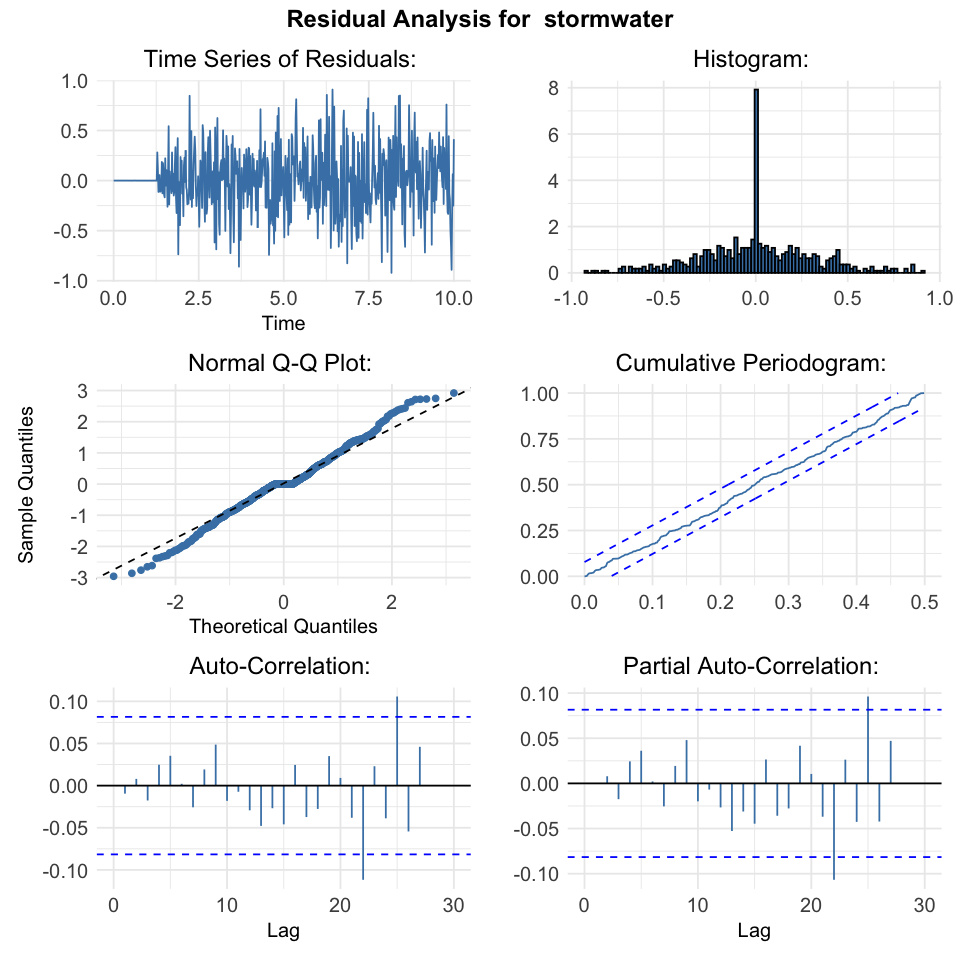

In [469]:
p = plot(fit3)
dev.off()
dev.set(2) # check which device vscode is using
print(p)

# 2.2

In [ ]:
plot_ctsm_fits <- function(model, data, 
                           response = "stormwater",
                           time_var = "t"
                          ) {
  
  pred <- model$predict(data = data)

  obs <- pred$observations

  df <- data.frame(
    time      = obs$t.j,              
    observed  = obs$stormwater.data,
    fitted    = obs$stormwater  
  )

  ggplot(df, aes(x = time)) +
    geom_point(aes(y = observed, colour = "Observed"), size = 1) +
    geom_line(aes(y = fitted, colour = "Fitted"), linewidth = 0.8) +
    labs(y = "Stormwater", colour = "") +
    theme_minimal()
}

# plot_ctsm_fits(model, data,
#                response = "stormwater",
#                time_var = "t")


In [ ]:
data <- read.csv("data/ex2_overflow.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)

# Convert timestamps to numeric time (hours since first observation)
data$t <- as.numeric(
  difftime(as.POSIXct(data$timestamp),
           as.POSIXct(data$timestamp[1]),
           units = "hours")
)

head(data)

timestamp           rainfall stormwater t         
1 2024-04-01 08:00:00 0.003    0          0.00000000
2 2024-04-01 08:01:00 0.000    0          0.01666667
3 2024-04-01 08:02:00 0.000    0          0.03333333
4 2024-04-01 08:03:00 0.000    0          0.05000000
5 2024-04-01 08:04:00 0.000    0          0.06666667
6 2024-04-01 08:05:00 0.000    0          0.08333333

In [ ]:
# p1 = plot(fit1)
# dev.off()
# dev.set(2) check which device vscode is using
# print()

In [ ]:
model <- ctsmTMB$new()

# With run-off for last state and K2
# model$addSystem(
#   dx1 ~  A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
#   dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
#   dx3 ~ (3/K) * x2 * dt -
#       (3/K) * x3 * dt -
#       (3/K2) * (1/(1 + exp(-alpha*(x3 - beta))) ) * x3 * dt +
#       sigma_x * dw3,
#   dx4 ~ (3/K2) * (1/(1 + exp(-alpha*(x3 - beta))) ) * x3 * dt +
#        sigma_x * dw4
# )

# Without run-off for last state and K2
# 5 state model
# model$addSystem(
#   dx1 ~  A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
#   dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
#   dx3 ~ (3 / K) * x2 * dt - (3 / K) * x3 * dt + sigma_x * dw3,
#   dx4 ~ (3/K) * x3 * dt - (3/K2) * (1/(1 + exp(-alpha*(x4 - beta))) ) * x4 * dt + sigma_x * dw4,
#   dx5 ~ (3/K2) * (1/(1 + exp(-alpha*(x4 - beta))) ) * x4 * dt + sigma_x * dw5
# )

# Without run-off for last state and K2
# 6 state model
# model$addSystem(
#   dx1 ~  A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
#   dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
#   dx3 ~ (3 / K) * x2 * dt - (3 / K) * x3 * dt + sigma_x * dw3,
#   dx4 ~ (3 / K) * x3 * dt - (3 / K) * x4 * dt + sigma_x * dw4,
#   dx5 ~ (3/K) * x4 * dt - (3/K2) * (1/(1 + exp(-alpha*(x5 - beta))) ) * x5 * dt + sigma_x * dw5,
#   dx6 ~ (3/K2) * (1/(1 + exp(-alpha*(x5 - beta))) ) * x5 * dt + sigma_x * dw6
# )

# 3 state model diff placement
# model$addSystem(
#   dx1 ~  A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
#   dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
#   dx3 ~ (3 / K) * x2 * dt - (3 / K2) * (1 / (1 + exp(-alpha * (x3 - beta))) * x3) * dt + sigma_x * dw3,
#   dx4 ~ (3 / K2) * (1 / (1 + exp(-alpha * (x3 - beta))) * x3) * dt + sigma_x * dw4
# )

model$addObs(stormwater ~ x4)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,    lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,    lower = 0.1,  upper = 15),
  beta    = c(initial = 6,    lower = 0.5,  upper = 10)
)

# model$setInitialState(list(c(0, 0, 0, 0), diag(c(0.1, 0.1, 0.1, 0.1))))

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0, x5 = 0, x6 = 0),
  p0 = diag(6) * 0.1 
))

fit <- model$estimate(data)
summary(fit)

ERROR: Error in check_parameter_vector(par.entry, par.name, self, private): The following parameter(s) is/are missing from the defined model (after applying algebraic substitutions):
         A


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:    -898.76839:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1337.2487:  1.95992  2.85074  1.17403 0.172385 0.000100000  4.94474  5.91982
 20:    -1407.9450:  1.23036  1.90387 0.296527 0.175546 0.000100000  4.88181  6.31862
 30:    -1412.2651:  1.23024  1.86979 0.273644 0.174091 0.000100000  4.85408  6.42101
 40:    -1413.5121:  1.23020  1.86466 0.270107 0.173915 0.000100000  4.84986  6.43634
 50:    -1414.1551:  1.22435  1.84262 0.268687 0.173820 0.000100000  4.78932  6.49087
 60:    -1414.2409:  1.22403  1.84190 0.268693 0.173827 0.000100000  4.78790  6.49177
 70:    -1414.7979:  1.18034  1.80044 0.255235 0.178816 0.000100000  4.46929  6.53184
 80:    -1415.4780:  1.17685  1.79884 0.253620 0.179297 0.000100000  4.43383  6.53338
 90:    -1416.6799:  1.16432  1.77071 0.254214 0.173179 0.000100000  4.45335  6.55700
100:    -1417.2027:  1.16558  1.77258 0.254659 0.171910 0.000100000  4.48957  6.54520
110:    -1417.5796:  1.16558  1.77260 0.254662 0.171908 

	 Optimization finished!:
            Elapsed time: 0.861 seconds.
            The objective value is: -1.428797e+03
            The maximum gradient component is: 3.1e+10
            The convergence message is: false convergence (8)
            Iterations: 176
            Evaluations: Fun: 382 Grad: 176
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value Pr(>|t|)
A       1.17359549        NaN     NaN      NaN
K       1.78882698         NA      NA       NA
K2      0.25536066        NaN     NaN      NaN
sigma_x 0.17217340        NaN     NaN      NaN
sigma_y 0.00018668         NA      NA       NA
alpha   4.53261725         NA      NA       NA
beta    6.51705795         NA      NA       NA


agg_record_449463130 
                   2

agg_record_449463130 
                   2

[[1]]



Checking and setting data...

Predicting with R...

Returning results...

Finished!



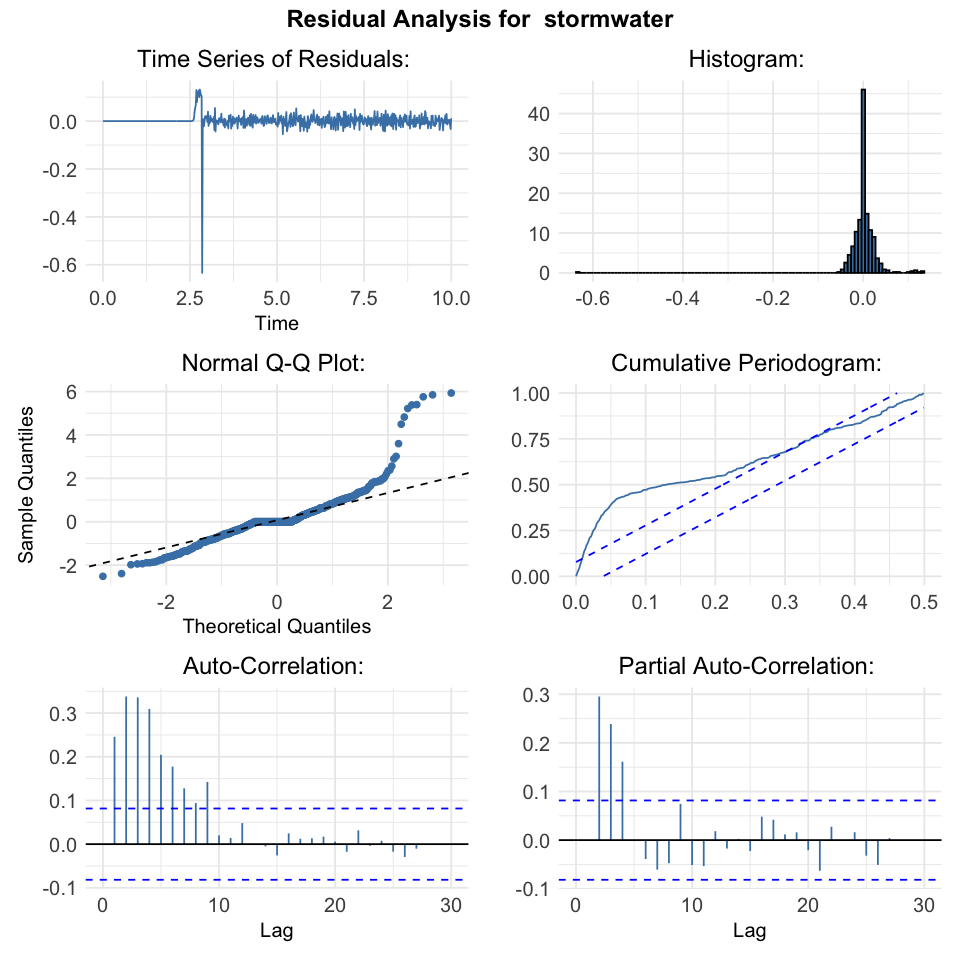

In [ ]:
model <- ctsmTMB$new()


# 3 state model
model$addSystem(
  dx1 ~  A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
  dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
  dx3 ~ (3 / K) * x2 * dt - (3 / K2) * (1 / (1 + exp(-alpha * (x3 - beta))) * x3) * dt + sigma_x * dw3,
  dx4 ~ (3 / K2) * (1 / (1 + exp(-alpha * (x3 - beta))) * x3) * dt + sigma_x * dw4
)

model$addObs(stormwater ~ x4)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,    lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,    lower = 0.1,  upper = 15),
  beta    = c(initial = 6,    lower = 0.5,  upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0),
  p0 = diag(4) * 0.1 
))

fit <- model$estimate(data)
summary(fit)

p1 = plot(fit)
dev.off()
dev.set(2) # check which device vscode is using
print(p1)



In [ ]:
head(data)

timestamp           rainfall stormwater t         
1 2024-04-01 08:00:00 0.003    0          0.00000000
2 2024-04-01 08:01:00 0.000    0          0.01666667
3 2024-04-01 08:02:00 0.000    0          0.03333333
4 2024-04-01 08:03:00 0.000    0          0.05000000
5 2024-04-01 08:04:00 0.000    0          0.06666667
6 2024-04-01 08:05:00 0.000    0          0.08333333

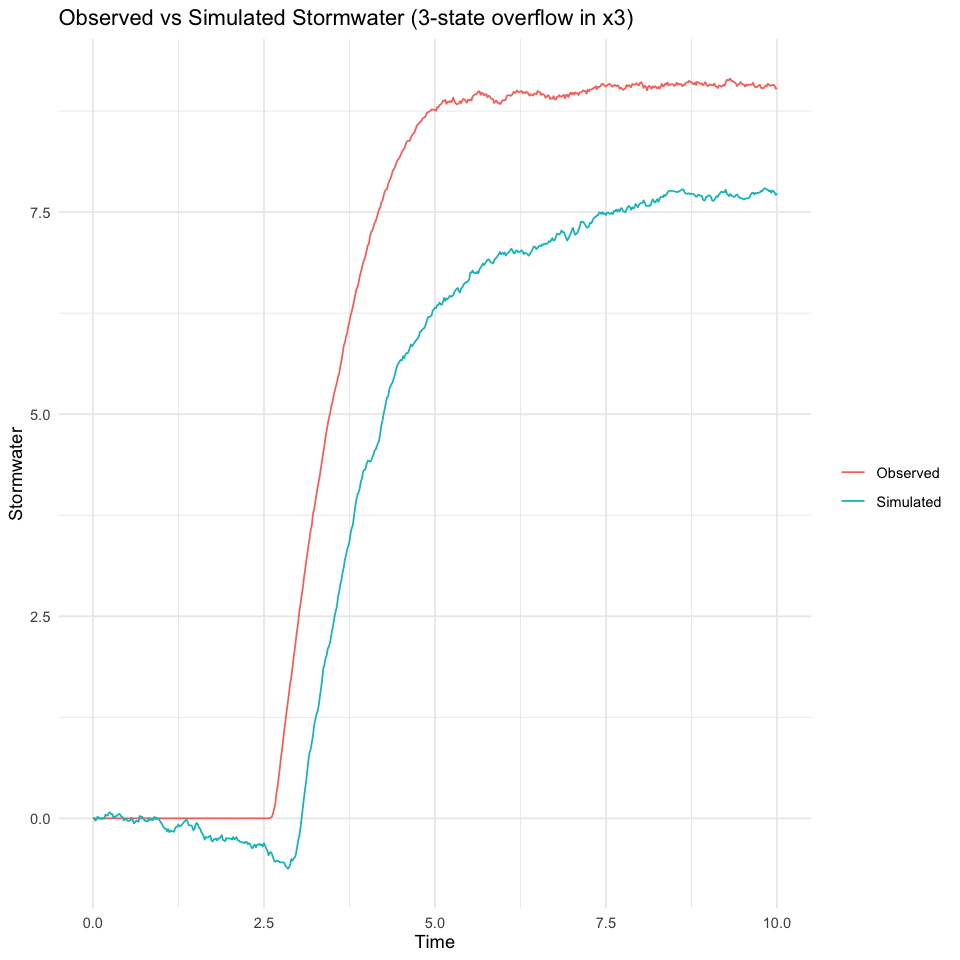

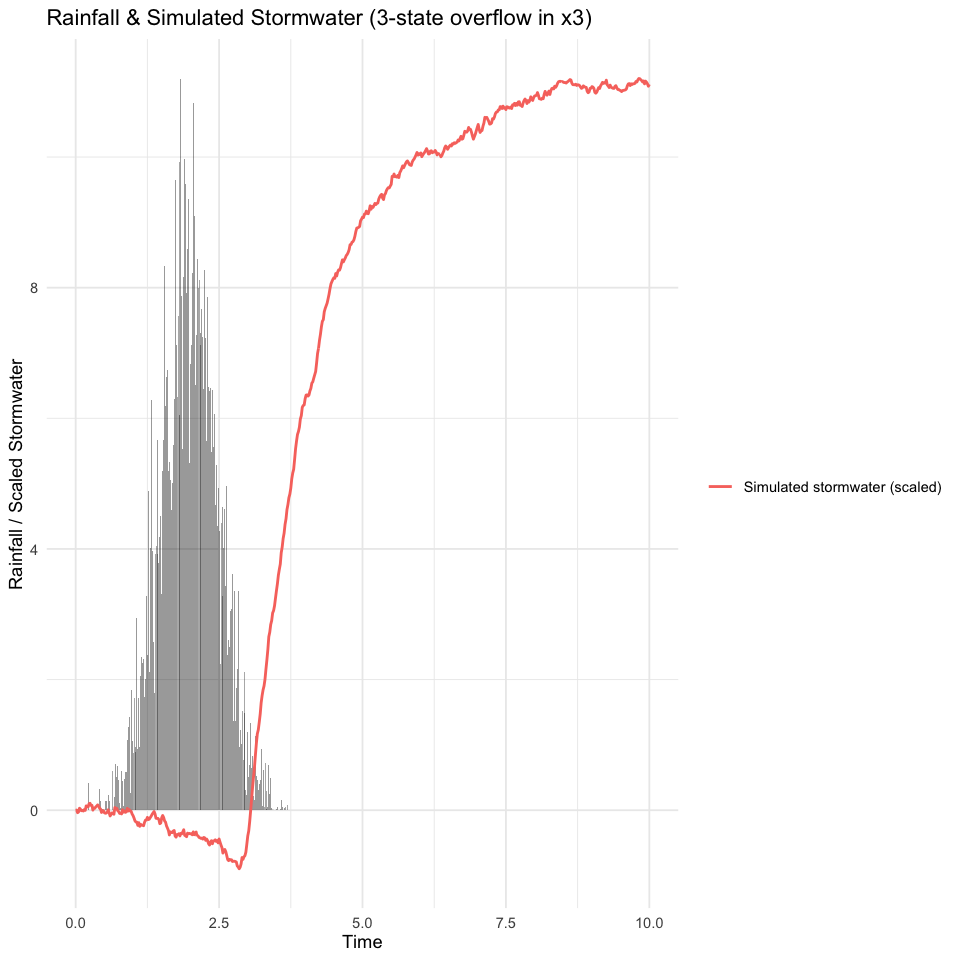

In [ ]:
library(ggplot2)

## ----- Pull parameters from fitted model --------------------------
pars    <- fit$par
A       <- pars["A"]
K       <- pars["K"]
K2      <- pars["K2"]
alpha   <- pars["alpha"]
beta    <- pars["beta"]
sigma_x <- pars["sigma_x"]

## Use same data as during estimation
data_sim <- data

## ----- Time handling (hours, as in assignment) --------------------
if ("t" %in% names(data_sim)) {
  time <- data_sim$t
} else if ("time" %in% names(data_sim)) {
  time <- data_sim$time
} else if ("timestamp" %in% names(data_sim)) {
  time <- as.numeric(
    difftime(as.POSIXct(data_sim$timestamp),
             as.POSIXct(data_sim$timestamp[1]),
             units = "hours")
  )
} else {
  time <- seq_len(nrow(data_sim))
}

time_num <- as.numeric(time)
n_t      <- length(time_num)

rain <- data_sim$rainfall
rain[!is.finite(rain)] <- 0

## ----- 4 states: X1, X2, X3 (overflow origin), X4 (observed) -----
X <- matrix(0, nrow = n_t, ncol = 4)
colnames(X) <- paste0("X", 1:4)

set.seed(123)
n_main <- 3   # because your model uses 3/K, 3/K2

for (i in 2:n_t) {

  dt_i <- time_num[i] - time_num[i - 1]
  stopifnot(is.finite(dt_i) && dt_i > 0)

  dw     <- rnorm(4, mean = 0, sd = sqrt(dt_i))
  X_prev <- X[i - 1, ]

  ## overflow sigmoid depends on X3 (your model)
  q3 <- 1 / (1 + exp(-alpha * (X_prev[3] - beta)))

  ## X1
  X[i, 1] <- X_prev[1] +
    (A * rain[i] -
     (n_main / K) * X_prev[1]) * dt_i +
    sigma_x * dw[1]

  ## X2
  X[i, 2] <- X_prev[2] +
    ((n_main / K) * X_prev[1] -
     (n_main / K) * X_prev[2]) * dt_i +
    sigma_x * dw[2]

  ## X3 (linear inflow from X2, nonlinear outflow)
  X[i, 3] <- X_prev[3] +
    ((n_main / K)  * X_prev[2] -
     (n_main / K2) * q3 * X_prev[3]) * dt_i +
    sigma_x * dw[3]

  ## X4 (overflow reservoir — observed)
  X[i, 4] <- X_prev[4] +
    ((n_main / K2) * q3 * X_prev[3]) * dt_i +
    sigma_x * dw[4]
}

## simulated stormwater = X4 (your addObs-statement)
stormwater_sim <- X[, 4]

df_plot <- data.frame(
  time      = time_num,
  observed  = data_sim$stormwater,
  simulated = stormwater_sim,
  rainfall  = data_sim$rainfall
)

## ----- PLOT 1: Observed vs Simulated stormwater ------------------
ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed,  colour = "Observed")) +
  geom_line(aes(y = simulated, colour = "Simulated")) +
  labs(title = "Observed vs Simulated Stormwater (3-state overflow in x3)",
       x = "Time", y = "Stormwater", colour = "") +
  theme_minimal()

## ----- PLOT 2: Rainfall + scaled simulated stormwater ------------
sim_scaled <- (
  stormwater_sim / max(stormwater_sim, na.rm = TRUE)
) * max(df_plot$rainfall, na.rm = TRUE)

df_plot$sim_scaled <- sim_scaled

ggplot(df_plot, aes(x = time)) +
  geom_col(aes(y = rainfall), fill = "black", alpha = 0.4) +
  geom_line(aes(y = sim_scaled,
                colour = "Simulated stormwater (scaled)"),
            linewidth = 0.8) +
  labs(title = "Rainfall & Simulated Stormwater (3-state overflow in x3)",
       x = "Time", y = "Rainfall / Scaled Stormwater", colour = "") +
  theme_minimal()


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     253.58051:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1443.9722:  3.71018  19.1375  2.16905 0.156644 0.000100000  4.73335  3.11364
 20:    -1538.2005:  3.00792  12.2535  2.69580 0.141023 0.00326166  11.3315  4.12385
 30:    -1539.3562:  3.00946  12.2635  2.69817 0.133092 0.00429038  11.3199  4.12269
 40:    -1544.0766:  3.05292  12.5908  2.42906 0.127724 0.00481430  12.8469  4.09121


	 Optimization finished!:
            Elapsed time: 0.152 seconds.
            The objective value is: -1.545331e+03
            The maximum gradient component is: 5.3e-01
            The convergence message is: relative convergence (4)
            Iterations: 49
            Evaluations: Fun: 84 Grad: 50
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A        3.0193051  0.0251812 119.903 < 2.2e-16 ***
K       12.9319929        NaN     NaN       NaN    
K2       2.3641680        NaN     NaN       NaN    
sigma_x  0.1254245        NaN     NaN       NaN    
sigma_y  0.0053012  0.0008638   6.137 1.537e-09 ***
alpha   15.0000000        NaN     NaN       NaN    
beta     3.9530003        NaN     NaN       NaN    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_1278090946 
                    2

agg_record_1278090946 
                    2

[[1]]



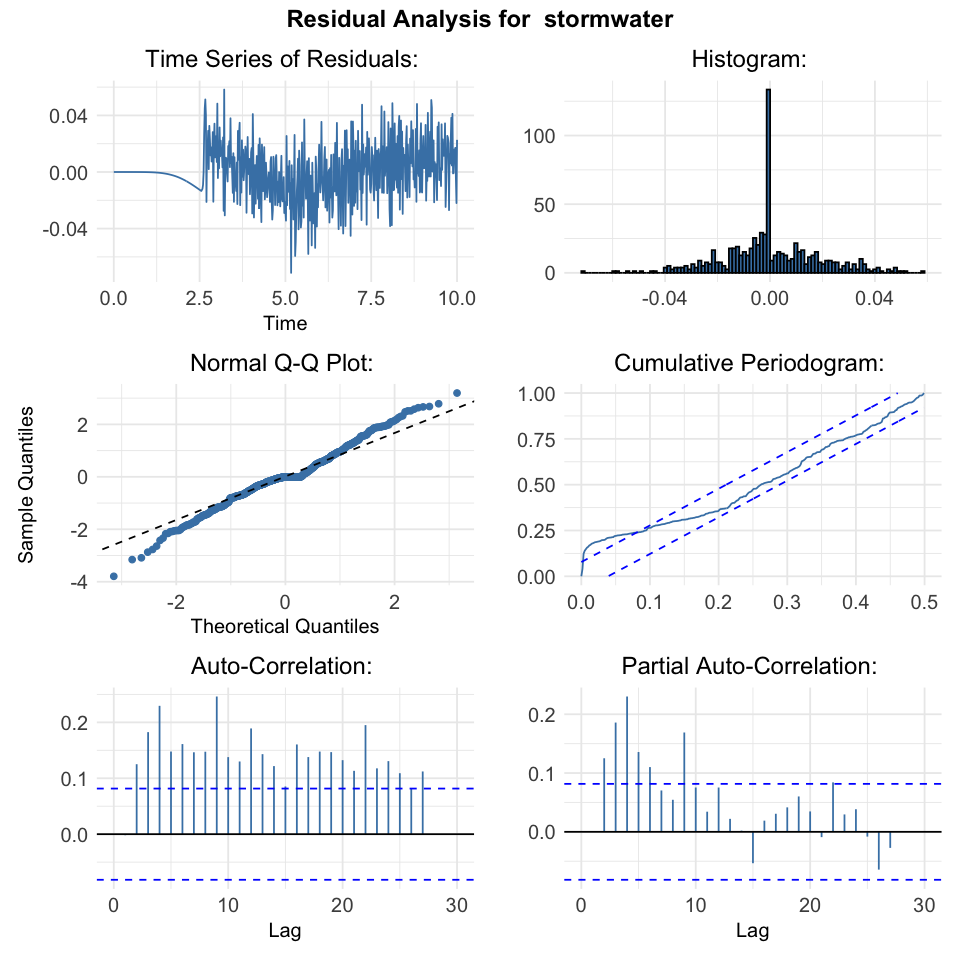

In [ ]:
model <- ctsmTMB$new()

# 3-state model, overflow from x2 to x3, x3 continues to x4, observe x3
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (3 / K)  * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (3 / K)  * x1 * dt
         - (3 / K)  * x2 * dt
         - (3 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw2,

  dx3 ~  (3 / K)  * x2 * dt
         - (3 / K)  * x3 * dt
         + (3 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw3,

  dx4 ~  (3 / K)  * x3 * dt
         + sigma_x * dw4
)

model$addObs(stormwater ~ x3)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0),
  p0 = diag(4) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     6522.8105:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1117.9982: 0.376991  20.0000  20.0000 0.289620 0.000100000 0.100000  9.91992
 20:    -1340.0693:  2.21252  20.0000  20.0000 0.205231 0.000100000 0.167708  9.86298


	 Optimization finished!:
            Elapsed time: 0.063 seconds.
            The objective value is: -1.342732e+03
            The maximum gradient component is: 8.2e+01
            The convergence message is: relative convergence (4)
            Iterations: 29
            Evaluations: Fun: 41 Grad: 30
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A        2.1100234  0.0960238 21.9740 < 2.2e-16 ***
K       20.0000000  1.1287909 17.7181 < 2.2e-16 ***
K2      20.0000000  3.2070397  6.2363  8.51e-10 ***
sigma_x  0.1996567  0.0057472 34.7401 < 2.2e-16 ***
sigma_y  0.0001000  0.0011014  0.0908    0.9277    
alpha    0.3487611  0.0506289  6.8886  1.44e-11 ***
beta    10.0000000        NaN     NaN       NaN    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_1461454002 
                    2

agg_record_1461454002 
                    2

[[1]]



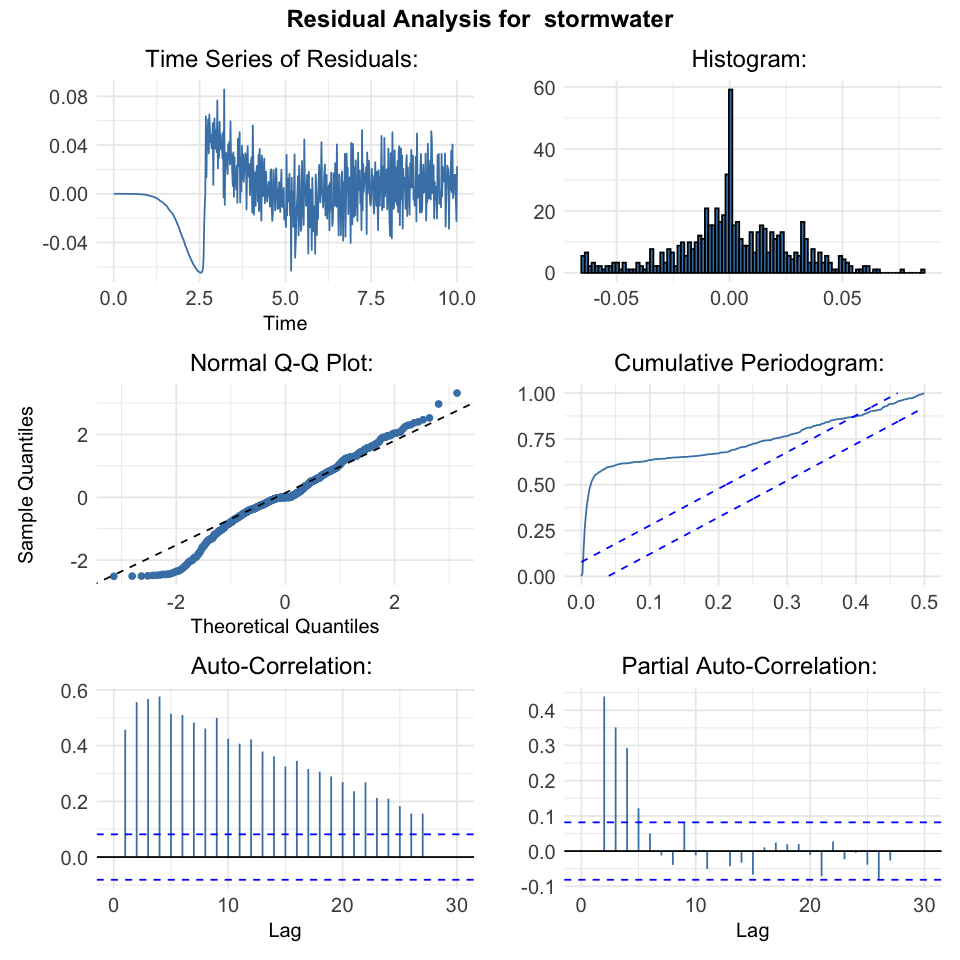

In [ ]:
model <- ctsmTMB$new()

# 3-state model, overflow from x1 to x2, x2 continues to x3, observe x2
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (3 / K)  * x1 * dt
         - (3 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (3 / K)  * x1 * dt
         - (3 / K)  * x2 * dt
         + (3 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         + sigma_x * dw2,

  dx3 ~  (3 / K)  * x2 * dt
         - (3 / K)  * x3 * dt
         + sigma_x * dw3,

  dx4 ~  (3 / K)  * x3 * dt
         + sigma_x * dw4
)

model$addObs(stormwater ~ x2)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0),
  p0 = diag(4) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:    -730.87259:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1501.9487:  4.18209  1.94835 0.847787 0.154777 0.000100000  4.79770  5.09127
 20:    -1539.9769:  3.50047  1.95611 0.686668 0.127233 0.00544664  4.60730  4.31071
 30:    -1547.5552:  3.33330  1.99934 0.631007 0.120101 0.00620909  4.55311  4.08620
 40:    -1568.6520:  2.38206  2.07572 0.118157 0.108951 0.00740593  4.49236  2.82190
 50:    -1573.8455:  2.40039  2.09523 0.0203319 0.113790 0.00667169  8.28736  2.76207
 60:    -1573.9052:  2.39806  2.09756 0.00736409 0.113412 0.00668776  8.32337  2.89094
 70:    -1573.9167:  2.39786  2.09754 0.00349967 0.113369 0.00669422  8.31757  2.98400
 80:    -1573.9220:  2.39781  2.09761 0.00151930 0.113370 0.00669461  8.30149  3.08867


	 Optimization finished!:
            Elapsed time: 0.507 seconds.
            The objective value is: -1.573923e+03
            The maximum gradient component is: 2.4e+00
            The convergence message is: relative convergence (4)
            Iterations: 88
            Evaluations: Fun: 145 Grad: 89
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A       2.3980e+00 1.0864e-01 22.0735 < 2.2e-16 ***
K       2.0974e+00 4.9145e-02 42.6782 < 2.2e-16 ***
K2      1.0000e-03 2.3393e-01  0.0043  0.996591    
sigma_x 1.1338e-01 5.8955e-03 19.2312 < 2.2e-16 ***
sigma_y 6.6928e-03 8.3217e-04  8.0426 4.784e-15 ***
alpha   8.2905e+00 2.8093e+00  2.9511  0.003291 ** 
beta    3.1406e+00 2.8341e+01  0.1108  0.911800    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_434510555 
                   2

agg_record_434510555 
                   2

[[1]]



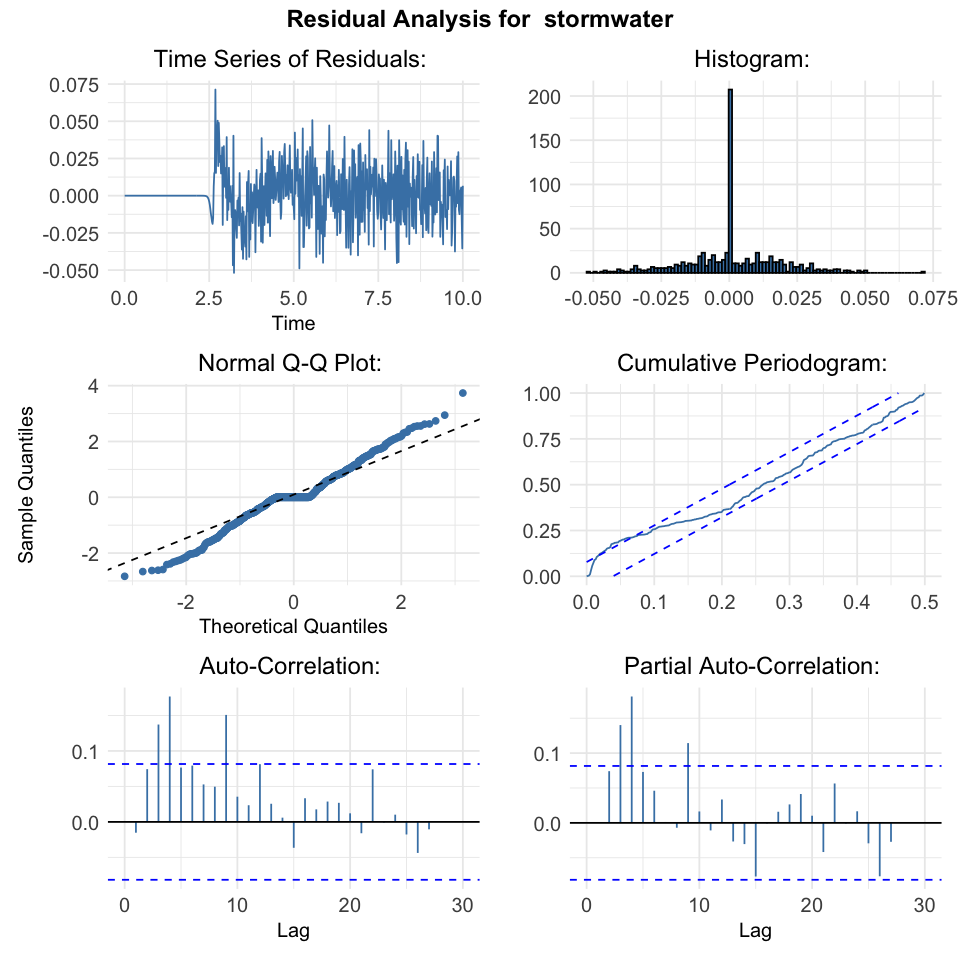

In [ ]:
model <- ctsmTMB$new()

# 4-state chain, overflow from x4 to x5, observe x5
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (4 / K) * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (4 / K) * x1 * dt
         - (4 / K) * x2 * dt
         + sigma_x * dw2,

  dx3 ~  (4 / K) * x2 * dt
         - (4 / K) * x3 * dt
         + sigma_x * dw3,

  dx4 ~  (4 / K)  * x3 * dt
         - (4 / K)  * x4 * dt
         - (4 / K2) * (1 / (1 + exp(-alpha * (x4 - beta)))) * x4 * dt
         + sigma_x * dw4,

  dx5 ~  (4 / K2) * (1 / (1 + exp(-alpha * (x4 - beta)))) * x4 * dt
         + sigma_x * dw5
)

model$addObs(stormwater ~ x5)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0, x5 = 0),
  p0 = diag(5) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     550.04843:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1303.2969:  4.17496  15.6663  1.15875 0.213990 0.000100000  1.25177  3.24821
 20:    -1344.9690:  3.48882  15.4766 0.178647 0.193075 0.000100000  1.74048  2.97880
 30:    -1432.7890:  3.77617  9.37612 0.354971 0.165244 0.000100000  4.24218  2.04998
 40:    -1440.0728:  3.67901  9.58775  1.43706 0.163445 0.000100000  7.77124  1.70002
 50:    -1446.6030:  3.64064  9.95386  1.52204 0.162341 0.000100000  15.0000  1.57094


	 Optimization finished!:
            Elapsed time: 0.216 seconds.
            The objective value is: -1.446604e+03
            The maximum gradient component is: 5.3e+01
            The convergence message is: relative convergence (4)
            Iterations: 54
            Evaluations: Fun: 79 Grad: 55
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A        3.6403369  0.1034608 35.1857 < 2.2e-16 ***
K        9.9548841  0.2901520 34.3092 < 2.2e-16 ***
K2       1.5220686  0.0748958 20.3225 < 2.2e-16 ***
sigma_x  0.1624773  0.0048272 33.6590 < 2.2e-16 ***
sigma_y  0.0001000  0.0013755  0.0727    0.9421    
alpha   15.0000000  2.6880036  5.5803 3.652e-08 ***
beta     1.5704127  0.0748678 20.9758 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_134869079 
                   2

agg_record_134869079 
                   2

[[1]]



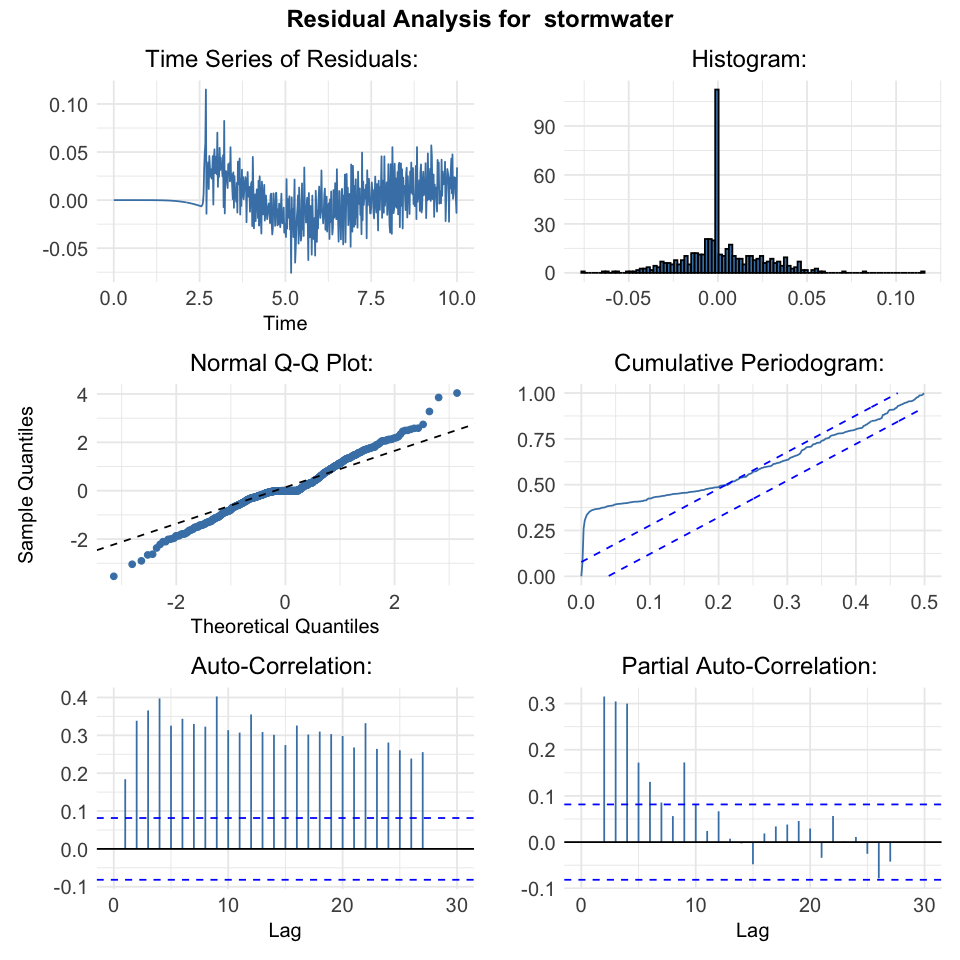

In [ ]:
model <- ctsmTMB$new()

# 4-state chain, overflow from x3 to x4, x4 continues to x5, observe x4
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (4 / K) * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (4 / K) * x1 * dt
         - (4 / K) * x2 * dt
         + sigma_x * dw2,

  dx3 ~  (4 / K) * x2 * dt
         - (4 / K) * x3 * dt
         - (4 / K2) * (1 / (1 + exp(-alpha * (x3 - beta)))) * x3 * dt
         + sigma_x * dw3,

  dx4 ~  (4 / K)  * x3 * dt
         - (4 / K)  * x4 * dt
         + (4 / K2) * (1 / (1 + exp(-alpha * (x3 - beta)))) * x3 * dt
         + sigma_x * dw4,

  dx5 ~  (4 / K) * x4 * dt
         + sigma_x * dw5
)

model$addObs(stormwater ~ x4)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0, x5 = 0),
  p0 = diag(5) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     2232.2092:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1348.0572:  3.74483  19.7304  4.87322 0.194345 0.000100000  3.22331  7.18258
 20:    -1479.4897:  2.27517  19.8359  3.96028 0.159700 0.000100000  4.20140  3.51522
 30:    -1513.6188:  2.89637  19.5352  3.09491 0.145841 0.000100000  4.58392  4.15109
 40:    -1531.3374:  3.16671  19.0740  2.36500 0.140095 0.00304457  5.07836  4.11979
 50:    -1541.7119:  3.04298  17.5559  3.10830 0.126998 0.00518283  8.15232  4.04911
 60:    -1543.8289:  3.08273  16.7447  3.18891 0.124374 0.00552370  12.5867  4.12459
 70:    -1545.3308:  3.01924  17.2405  3.15205 0.125356 0.00531647  15.0000  3.95312


	 Optimization finished!:
            Elapsed time: 0.254 seconds.
            The objective value is: -1.545331e+03
            The maximum gradient component is: 5.3e-01
            The convergence message is: relative convergence (4)
            Iterations: 73
            Evaluations: Fun: 126 Grad: 74
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error  t value  Pr(>|t|)    
A       3.0193e+00 2.5155e-02 120.0261 < 2.2e-16 ***
K       1.7243e+01        NaN      NaN       NaN    
K2      3.1522e+00        NaN      NaN       NaN    
sigma_x 1.2542e-01        NaN      NaN       NaN    
sigma_y 5.3012e-03 8.6374e-04   6.1375 1.533e-09 ***
alpha   1.5000e+01        NaN      NaN       NaN    
beta    3.9530e+00        NaN      NaN       NaN    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_255925280 
                   2

agg_record_255925280 
                   2

[[1]]



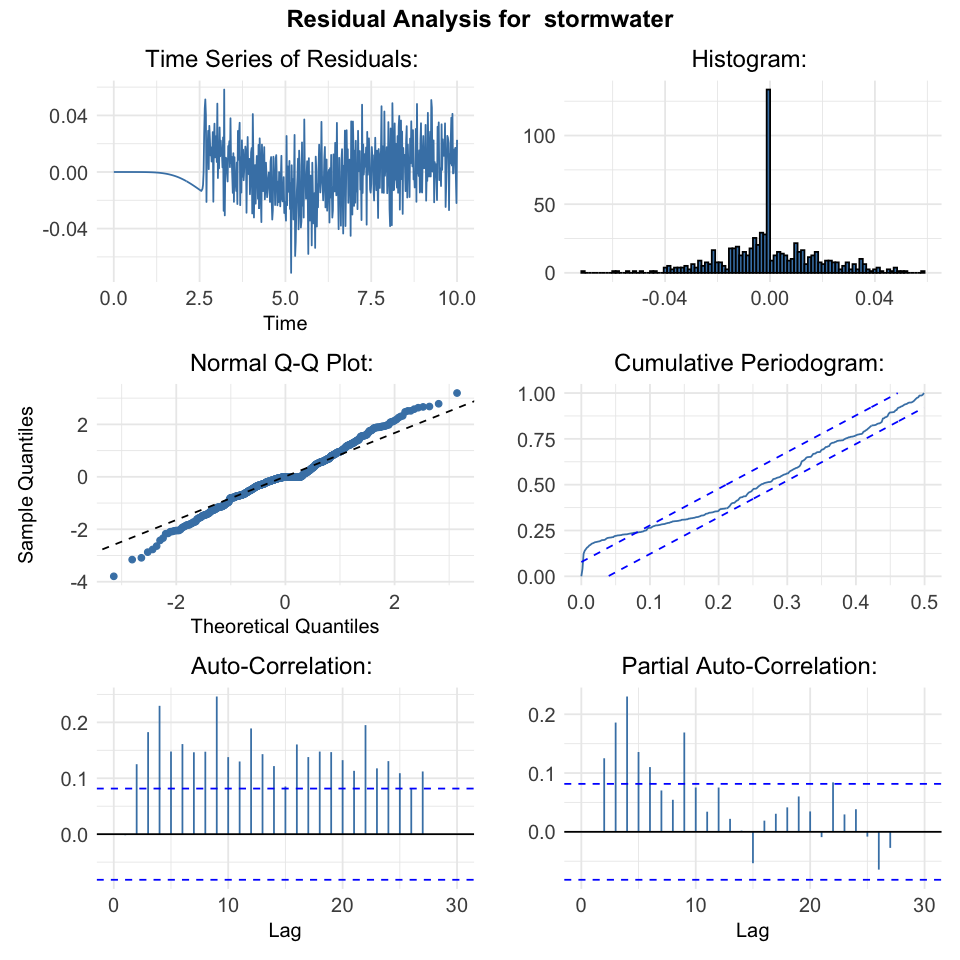

In [ ]:
model <- ctsmTMB$new()

# 4-state chain, overflow from x2 to x3, x3 continues to x4, observe x3
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (4 / K) * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (4 / K) * x1 * dt
         - (4 / K) * x2 * dt
         - (4 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw2,

  dx3 ~  (4 / K) * x2 * dt
         - (4 / K) * x3 * dt
         + (4 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw3,

  dx4 ~  (4 / K) * x3 * dt
         - (4 / K) * x4 * dt
         + sigma_x * dw4,

  dx5 ~  (4 / K) * x4 * dt
         + sigma_x * dw5
)

model$addObs(stormwater ~ x3)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0, x5 = 0),
  p0 = diag(5) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     9024.9394:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -986.29753: 1.00000e-06  20.0000  20.0000 0.439797 0.000100000  12.9900  8.65875
 20:    -1260.2171:  1.80088  20.0000  20.0000 0.228889 0.000100000  13.4571  7.82600
 30:    -1297.0144:  2.10939  20.0000  20.0000 0.220401 0.000100000 0.100000  9.65197


	 Optimization finished!:
            Elapsed time: 0.067 seconds.
            The objective value is: -1.298416e+03
            The maximum gradient component is: 8.3e+01
            The convergence message is: relative convergence (4)
            Iterations: 36
            Evaluations: Fun: 43 Grad: 37
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A        2.0443931  0.0913376 22.3828 < 2.2e-16 ***
K       20.0000000  0.7971842 25.0883 < 2.2e-16 ***
K2      20.0000000  2.6103135  7.6619 7.490e-14 ***
sigma_x  0.2150807  0.0067879 31.6861 < 2.2e-16 ***
sigma_y  0.0001000  0.0010998  0.0909    0.9276    
alpha    0.1000000  0.0145458  6.8748 1.575e-11 ***
beta    10.0000000        NaN     NaN       NaN    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_889572970 
                   2

agg_record_889572970 
                   2

[[1]]



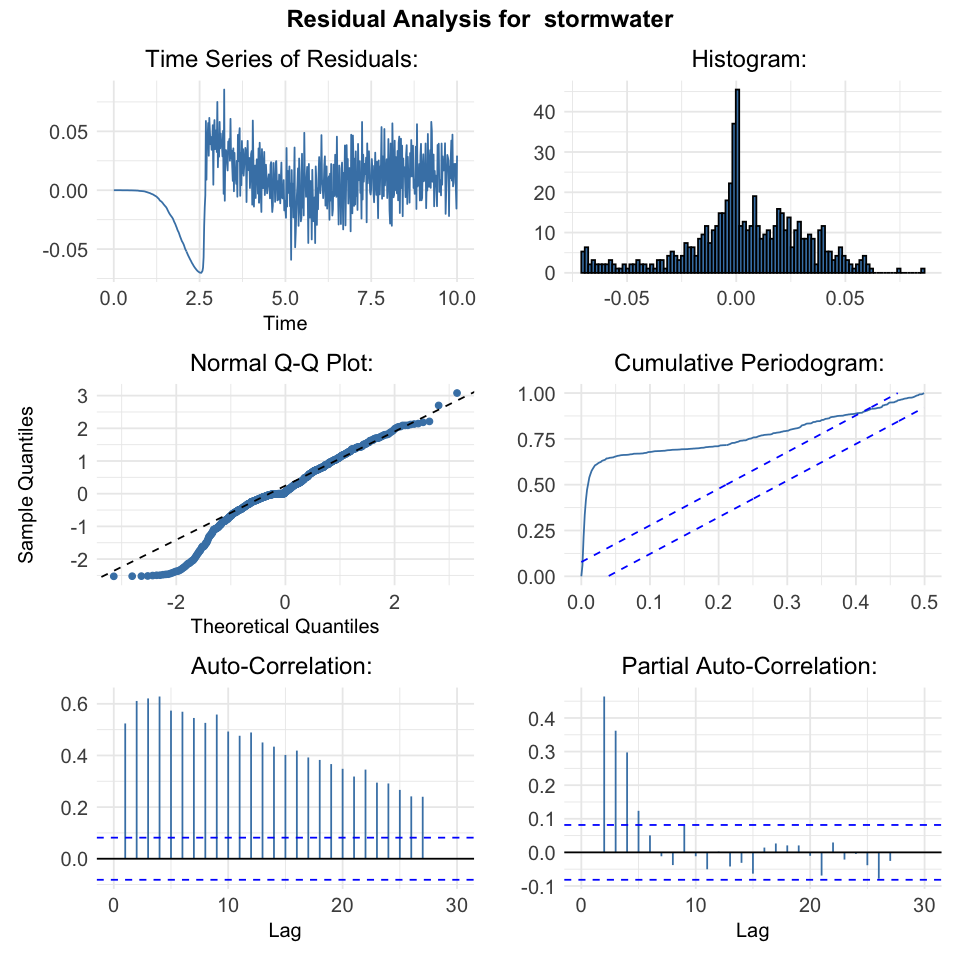

In [ ]:
model <- ctsmTMB$new()

# 4-state chain, overflow from x1 to x2, x2 continues to x3, observe x2
model$addSystem(
  dx1 ~  A * rainfall * dt
         - (4 / K) * x1 * dt
         - (4 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         + sigma_x * dw1,

  dx2 ~  (4 / K) * x1 * dt
         - (4 / K) * x2 * dt
         + (4 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         + sigma_x * dw2,

  dx3 ~  (4 / K) * x2 * dt
         - (4 / K) * x3 * dt
         + sigma_x * dw3,

  dx4 ~  (4 / K) * x3 * dt
         - (4 / K) * x4 * dt
         + sigma_x * dw4,

  dx5 ~  (4 / K) * x4 * dt
         + sigma_x * dw5
)

model$addObs(stormwater ~ x2)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,  lower = 1e-6, upper = 10),
  K       = c(initial = 4,  lower = 1e-3, upper = 20),
  K2      = c(initial = 1,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,   lower = 0.1, upper = 15),
  beta    = c(initial = 6,   lower = 0.5, upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0, x4 = 0, x5 = 0),
  p0 = diag(5) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 <- plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:    -1544.5530:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1611.1374:  2.97071  4.00230  1.00065 0.100045 0.00777525  5.00338  6.02317
 20:    -1620.4469:  3.14138  3.69126 0.762323 0.0798630 0.00920625  5.23904  6.75156
 30:    -1632.2636:  3.27135  4.02798 0.424278 0.0786543 0.00933581  8.06439  7.19503
 40:    -1632.4819:  3.26042  4.04912  1.14377 0.0783976 0.00934033  10.4827  6.95753


	 Optimization finished!:
            Elapsed time: 0.126 seconds.
            The objective value is: -1.632482e+03
            The maximum gradient component is: 4.2e-02
            The convergence message is: relative convergence (4)
            Iterations: 42
            Evaluations: Fun: 65 Grad: 43
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value Pr(>|t|)    
A       3.2604e+00 7.3001e-02 44.6627  < 2e-16 ***
K       4.0491e+00 1.0036e-01 40.3451  < 2e-16 ***
K2      1.1427e+00 8.4201e-01  1.3571  0.17525    
sigma_x 7.8398e-02 5.1583e-03 15.1985  < 2e-16 ***
sigma_y 9.3403e-03 5.7106e-04 16.3562  < 2e-16 ***
alpha   1.0482e+01 4.7132e+00  2.2241  0.02652 *  
beta    6.9577e+00 3.2580e-01 21.3556  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_913910578 
                   2

agg_record_913910578 
                   2

[[1]]



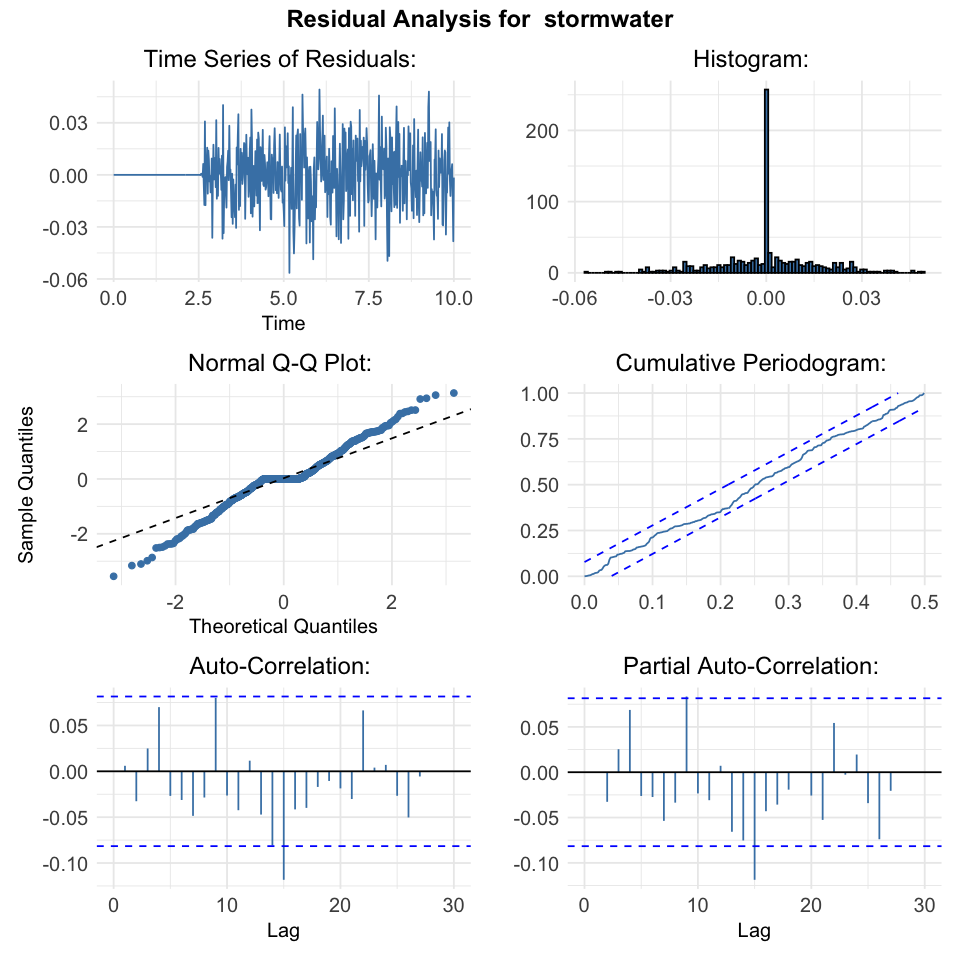

In [470]:
model <- ctsmTMB$new()

# 2-state SDE system (X1, X2) + overflow reservoir X3
model$addSystem(
  # X1: linear reservoir with rainfall input
  dx1 ~  A * rainfall * dt
         - (2 / K) * x1 * dt
         + sigma_x * dw1,

  # X2: linear reservoir + nonlinear overflow to X3
  dx2 ~  (2 / K) * x1 * dt
         - (2 / K) * x2 * dt
         - (2 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw2,

  # X3: receives overflow only
  dx3 ~  (2 / K2) * (1 / (1 + exp(-alpha * (x2 - beta)))) * x2 * dt
         + sigma_x * dw3
)

model$addObs(stormwater ~ x3)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,    lower = 1e-6, upper = 10),
  K       = c(initial = 4,    lower = 1e-3, upper = 20),
  K2      = c(initial = 1,    lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,    lower = 0.1,  upper = 15),
  beta    = c(initial = 6,    lower = 0.5,  upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0),
  p0 = diag(3) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 = plot(fit)
dev.off()
dev.set(2)
print(p1)


Checking and setting data...

Predicting with R...



Returning results...

Finished!



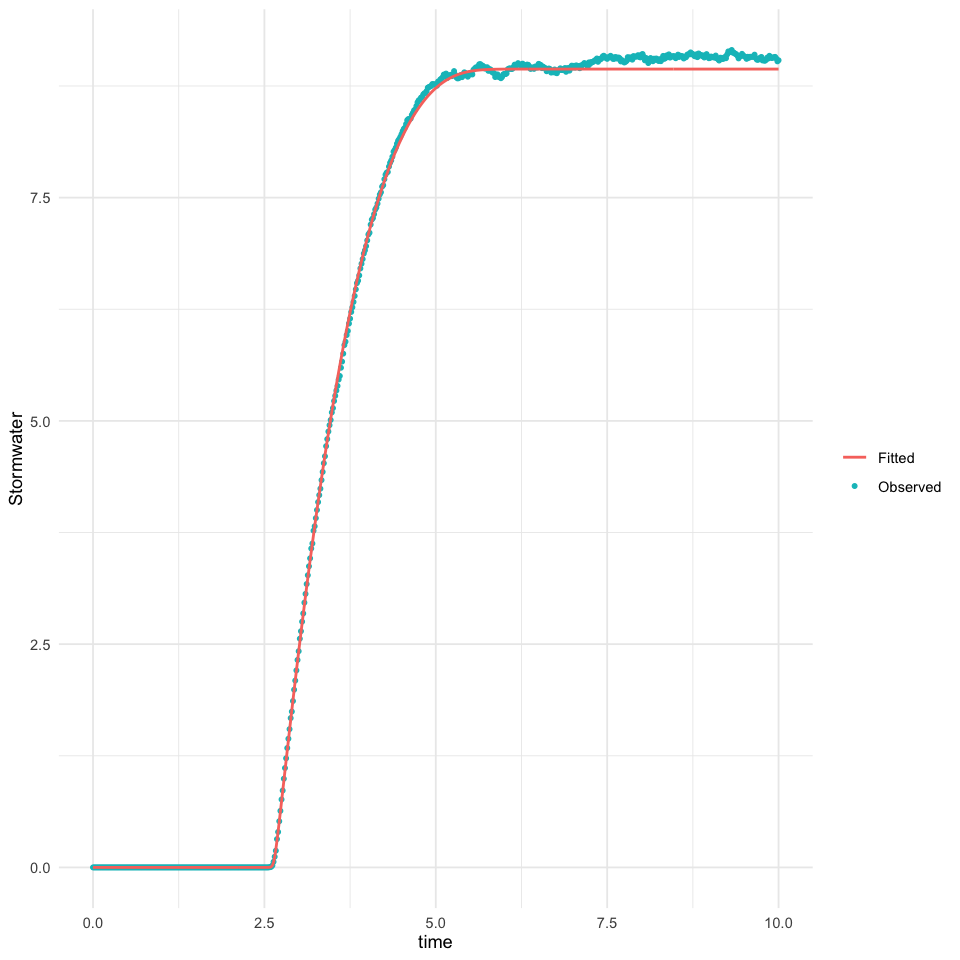

In [471]:
plot_ctsm_fits(model, data,
               response = "stormwater",
               time_var = "t")


In [472]:
cov_mat <- fit$cov.fixed

cor_mat <- cov2cor(cov_mat)

round(cor_mat, 3)

A      K      K2     sigma_x sigma_y alpha  beta  
A        1.000 -0.218 -0.114  0.030  -0.015  -0.237  0.776
K       -0.218  1.000  0.409 -0.077   0.038   0.603 -0.410
K2      -0.114  0.409  1.000  0.010  -0.005   0.857 -0.563
sigma_x  0.030 -0.077  0.010  1.000  -0.582  -0.068  0.035
sigma_y -0.015  0.038 -0.005 -0.582   1.000   0.035 -0.017
alpha   -0.237  0.603  0.857 -0.068   0.035   1.000 -0.650
beta     0.776 -0.410 -0.563  0.035  -0.017  -0.650  1.000

Checking and setting data...

Predicting with R...

Returning results...

Finished!

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


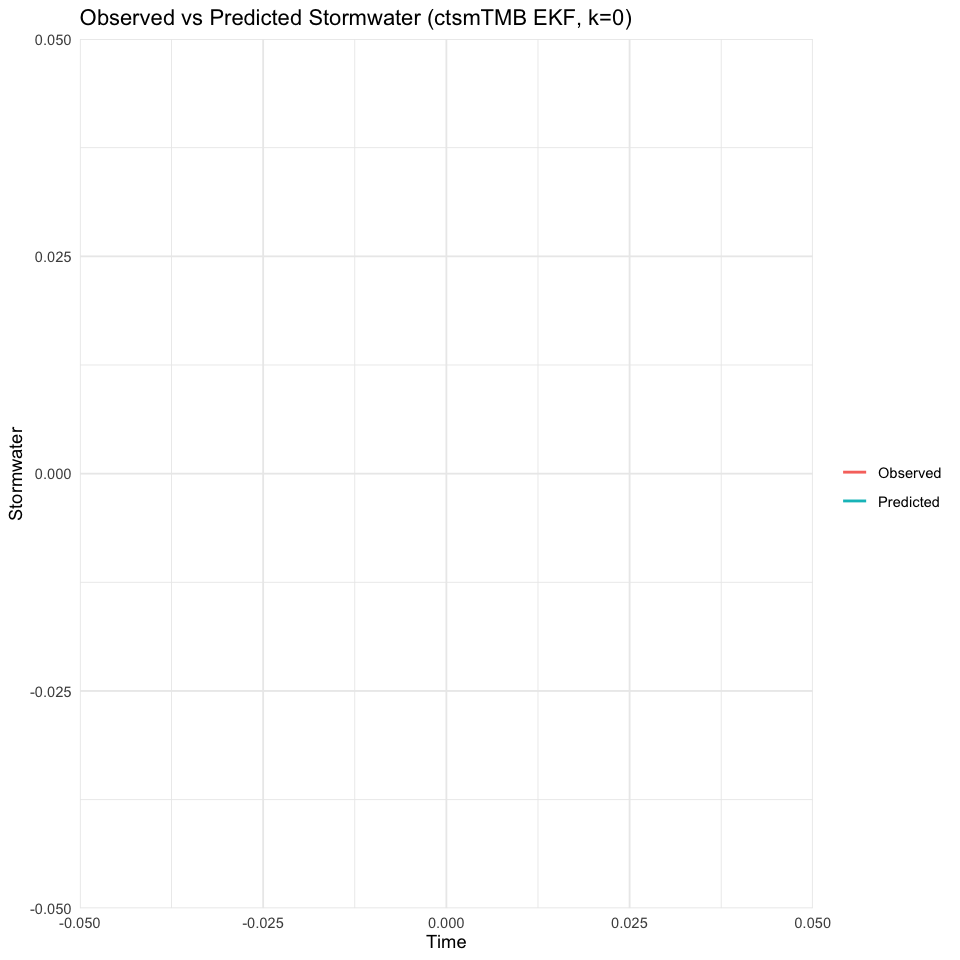

In [ ]:
pred <- model$predict(data = data)

# Filter to k = 0 (EKF filtered estimate)
filt <- pred$observations[pred$observations$k.ahead == 0, ]

df <- data.frame(
  time      = filt$t.j,
  observed  = filt$stormwater.data,
  predicted = filt$stormwater
)

library(ggplot2)

ggplot(df, aes(x = time)) +
  geom_line(aes(y = observed,  colour = "Observed"), linewidth = 0.8) +
  geom_line(aes(y = predicted, colour = "Predicted"), linewidth = 0.8) +
  labs(
    title  = "Observed vs Predicted Stormwater (ctsmTMB EKF, k=0)",
    x      = "Time",
    y      = "Stormwater",
    colour = ""
  ) +
  theme_minimal()


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     4851.1055:  3.00000  4.00000  1.00000 0.150000 0.0100000  5.00000  6.00000
 10:    -1237.9781: 0.394873  20.0000 0.0315772 0.285014 0.000100000 0.835060  10.0000
 20:    -1299.5524: 0.689820  20.0000 0.150830 0.200924 0.000100000  1.00623  10.0000
 30:    -1341.2730:  1.04856  20.0000  3.22697 0.192209 0.000100000  1.20834  10.0000
 40:    -1365.8627:  1.09625  20.0000  7.57271 0.185052 0.000100000  3.10461  10.0000


	 Optimization finished!:
            Elapsed time: 0.076 seconds.
            The objective value is: -1.365863e+03
            The maximum gradient component is: 7.6e+01
            The convergence message is: relative convergence (4)
            Iterations: 43
            Evaluations: Fun: 52 Grad: 44
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A        1.0961991  0.2545006  4.3073 1.934e-05 ***
K       20.0000000  2.0906554  9.5664 < 2.2e-16 ***
K2       7.5724671  1.6737639  4.5242 7.323e-06 ***
sigma_x  0.1850535  0.0068632 26.9631 < 2.2e-16 ***
sigma_y  0.0001000  0.0011461  0.0873    0.9305    
alpha    3.1174297  0.4784527  6.5156 1.545e-10 ***
beta    10.0000000  1.9929530  5.0177 6.919e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


agg_record_1461454002 
                    2

agg_record_1461454002 
                    2

[[1]]



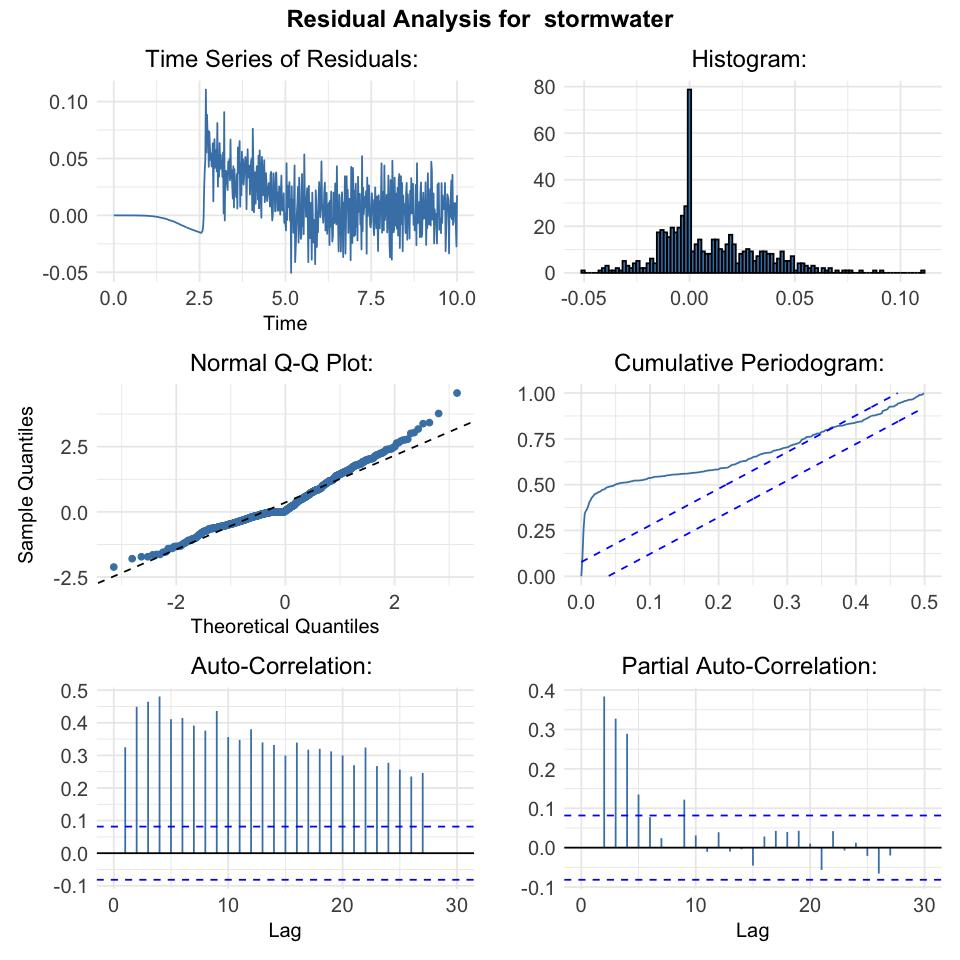

In [ ]:
model <- ctsmTMB$new()

# 2-state SDE system (X1, X2) + downstream reservoir X3
model$addSystem(
  # X1: linear + nonlinear overflow to X2
  dx1 ~  A * rainfall * dt
         - (2 / K) * x1 * dt
         - (2 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         + sigma_x * dw1,

  # X2: receives overflow from X1 + linear routing from X1
  dx2 ~  (2 / K)  * x1 * dt
         + (2 / K2) * (1 / (1 + exp(-alpha * (x1 - beta)))) * x1 * dt
         - (2 / K) * x2 * dt
         + sigma_x * dw2,

  # X3: pure linear downstream (not observed)
  dx3 ~  (2 / K) * x2 * dt
         - (2 / K) * x3 * dt
         + sigma_x * dw3
)

model$addObs(stormwater ~ x2)   # overflow reservoir is the observation
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 3,    lower = 1e-6, upper = 10),
  K       = c(initial = 4,    lower = 1e-3, upper = 20),
  K2      = c(initial = 1,    lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,    lower = 0.1,  upper = 15),
  beta    = c(initial = 6,    lower = 0.5,  upper = 10)
)

model$setInitialState(list(
  x0 = c(x1 = 0, x2 = 0, x3 = 0),
  p0 = diag(3) * 0.1
))

fit <- model$estimate(data)
summary(fit)

p1 = plot(fit)
dev.off()
dev.set(2)
print(p1)


# 2.3

In [ ]:
library("e1071")
library("ctsmTMB")
library("dplyr")
library("lubridate")
library("readr")


Attaching package: ‘e1071’


The following object is masked from ‘package:ggplot2’:

    element



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## 2.3.1

In [ ]:
data <- read.csv("data/ex3_largecase.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)

In [ ]:
head(data)

Timestamp           Rainfall Pumpflow  Volume   Event_ID
1 2018-08-12 04:00:00 0        0.6111000 53.61126 1       
2 2018-08-12 04:05:00 0        1.2898000 55.24896 1       
3 2018-08-12 04:10:00 0        1.6896333 56.34076 1       
4 2018-08-12 04:15:00 0        0.5513333 60.16207 1       
5 2018-08-12 04:20:00 0        1.6400000 60.16207 1       
6 2018-08-12 04:25:00 0        1.7393667 58.52436 1

In [ ]:
data <- data %>%
  mutate(
    time = as.POSIXct(Timestamp, format = "%Y-%m-%d %H:%M:%S", tz = "UTC"),
    t = as.numeric(difftime(time, min(time), units = "hour")),
    Pumpflow1000 = Pumpflow * 1/1000,
    Volume1000 = Volume * 1/1000
  ) %>%
  arrange(t) %>%
  select(t, Rainfall, Pumpflow, Pumpflow1000,Volume, Volume1000,Event_ID)

In [ ]:
head(data)
nrow(data)

t          Rainfall Pumpflow  Pumpflow1000 Volume   Volume1000 Event_ID
1 0.00000000 0        0.6111000 0.0006111000 53.61126 0.05361126 1       
2 0.08333333 0        1.2898000 0.0012898000 55.24896 0.05524896 1       
3 0.16666667 0        1.6896333 0.0016896333 56.34076 0.05634076 1       
4 0.25000000 0        0.5513333 0.0005513333 60.16207 0.06016207 1       
5 0.33333333 0        1.6400000 0.0016400000 60.16207 0.06016207 1       
6 0.41666667 0        1.7393667 0.0017393667 58.52436 0.05852436 1

[1] 1590

In [ ]:
plot_event <- function(data,ID){
  Event <- data[data$Event_ID==ID,]

  matplot(
    x = Event$t,
    y = Event[, c("Rainfall", "Pumpflow", "Volume1000")],
    type = "l",
    lty = 1,
    col = 1:3,
    xlab = "Time",
    ylab = "Value",
    main = paste0("Event ",ID)
  )
  
  legend("topleft", legend = c("Rainfall μm/min", "Pumpflow m³/min", "Volume 1000 m³/min"), col = 1:3, lty = 1)  
}

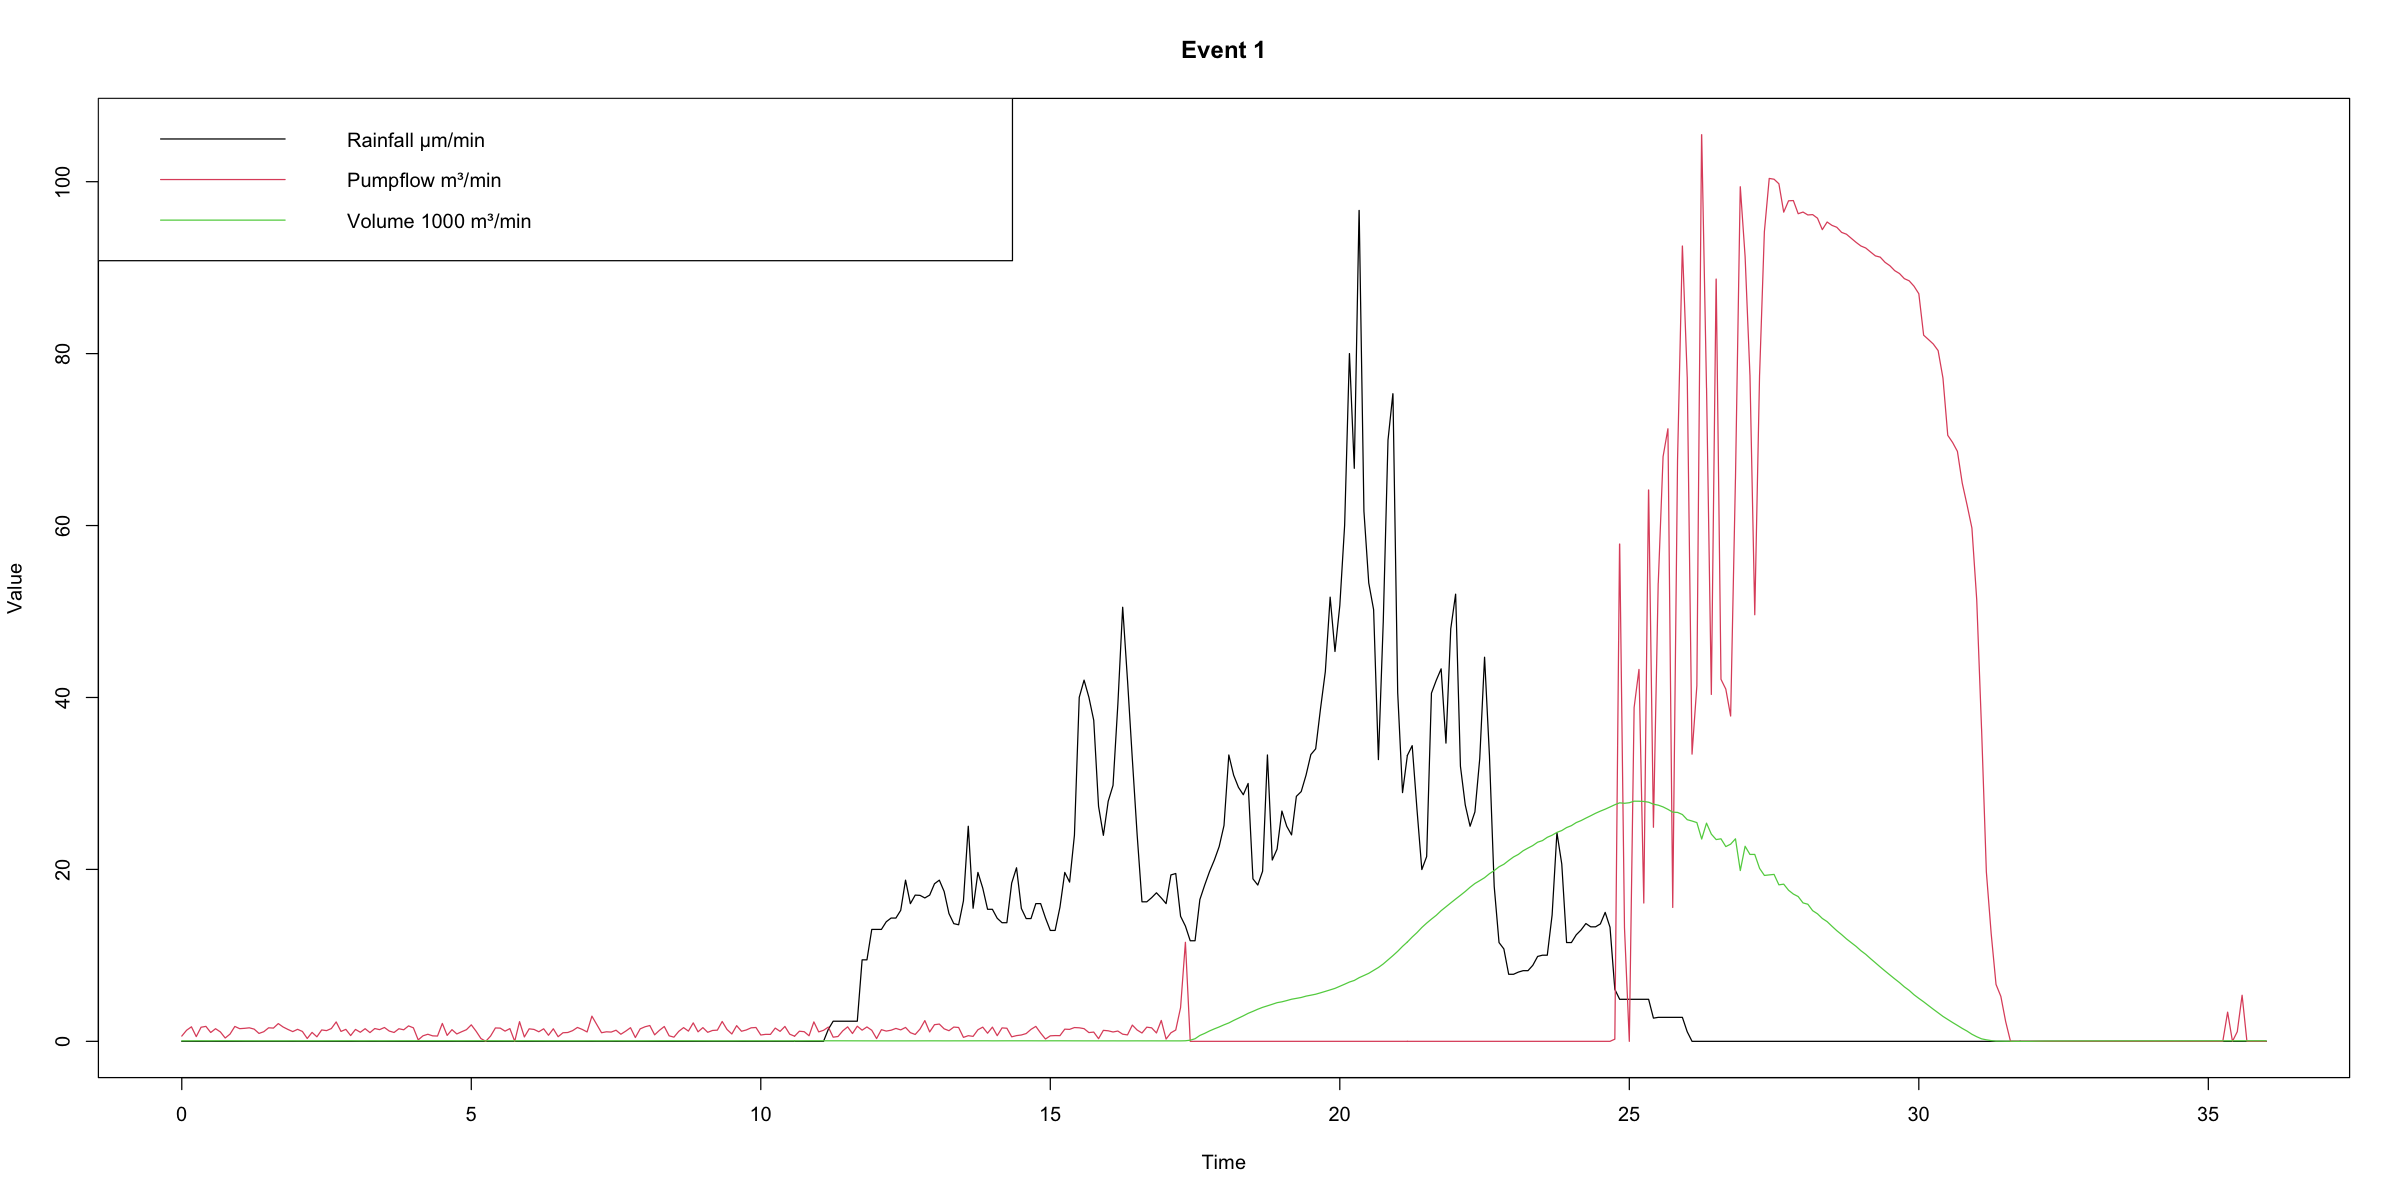

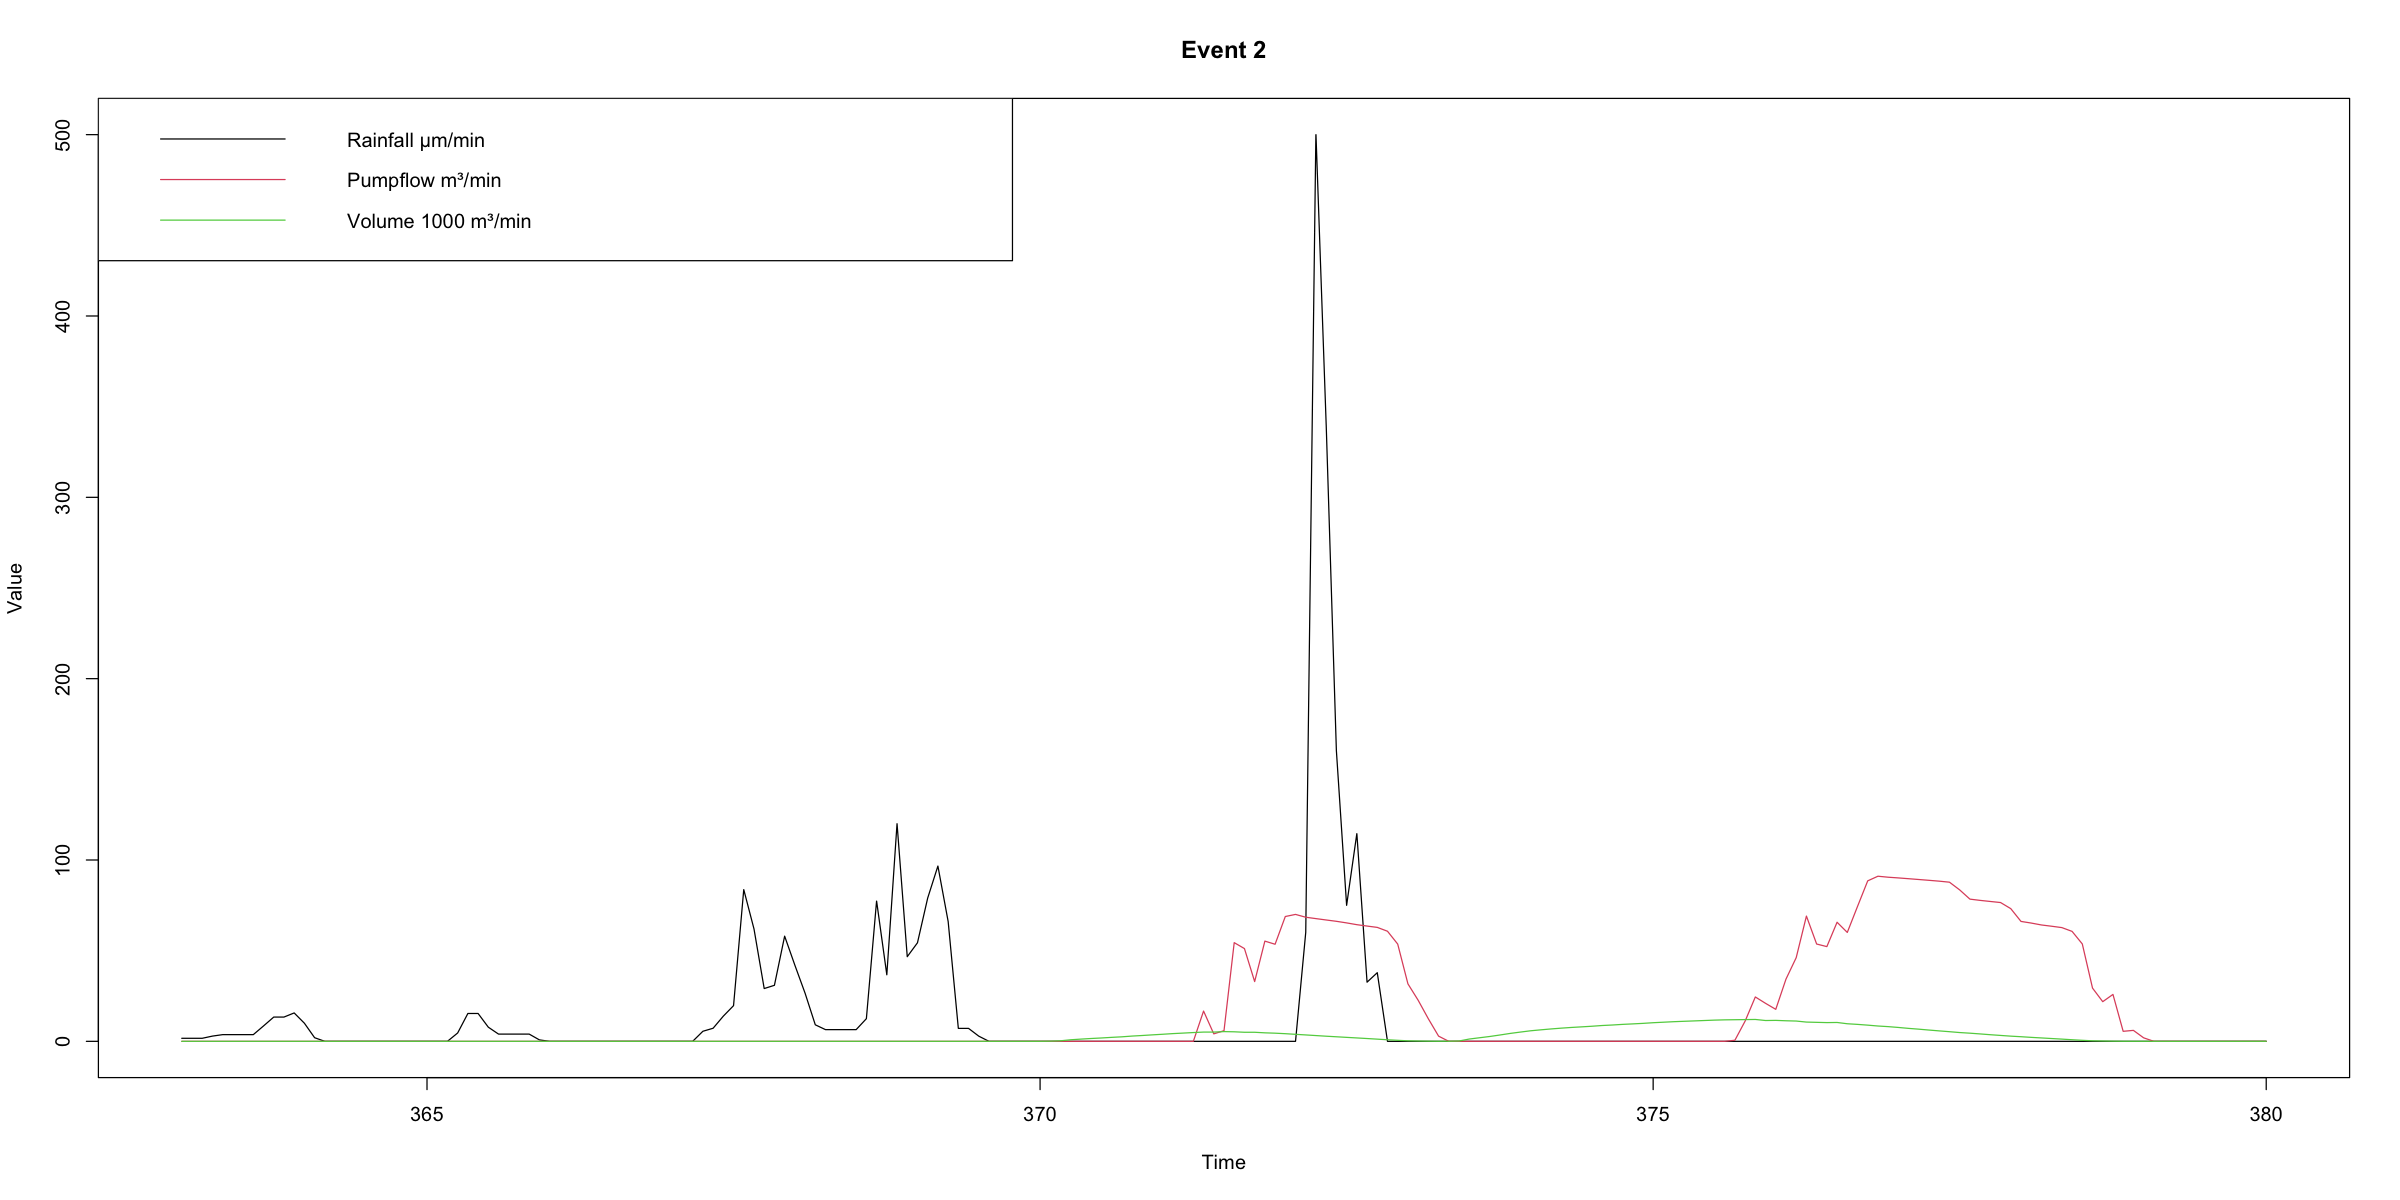

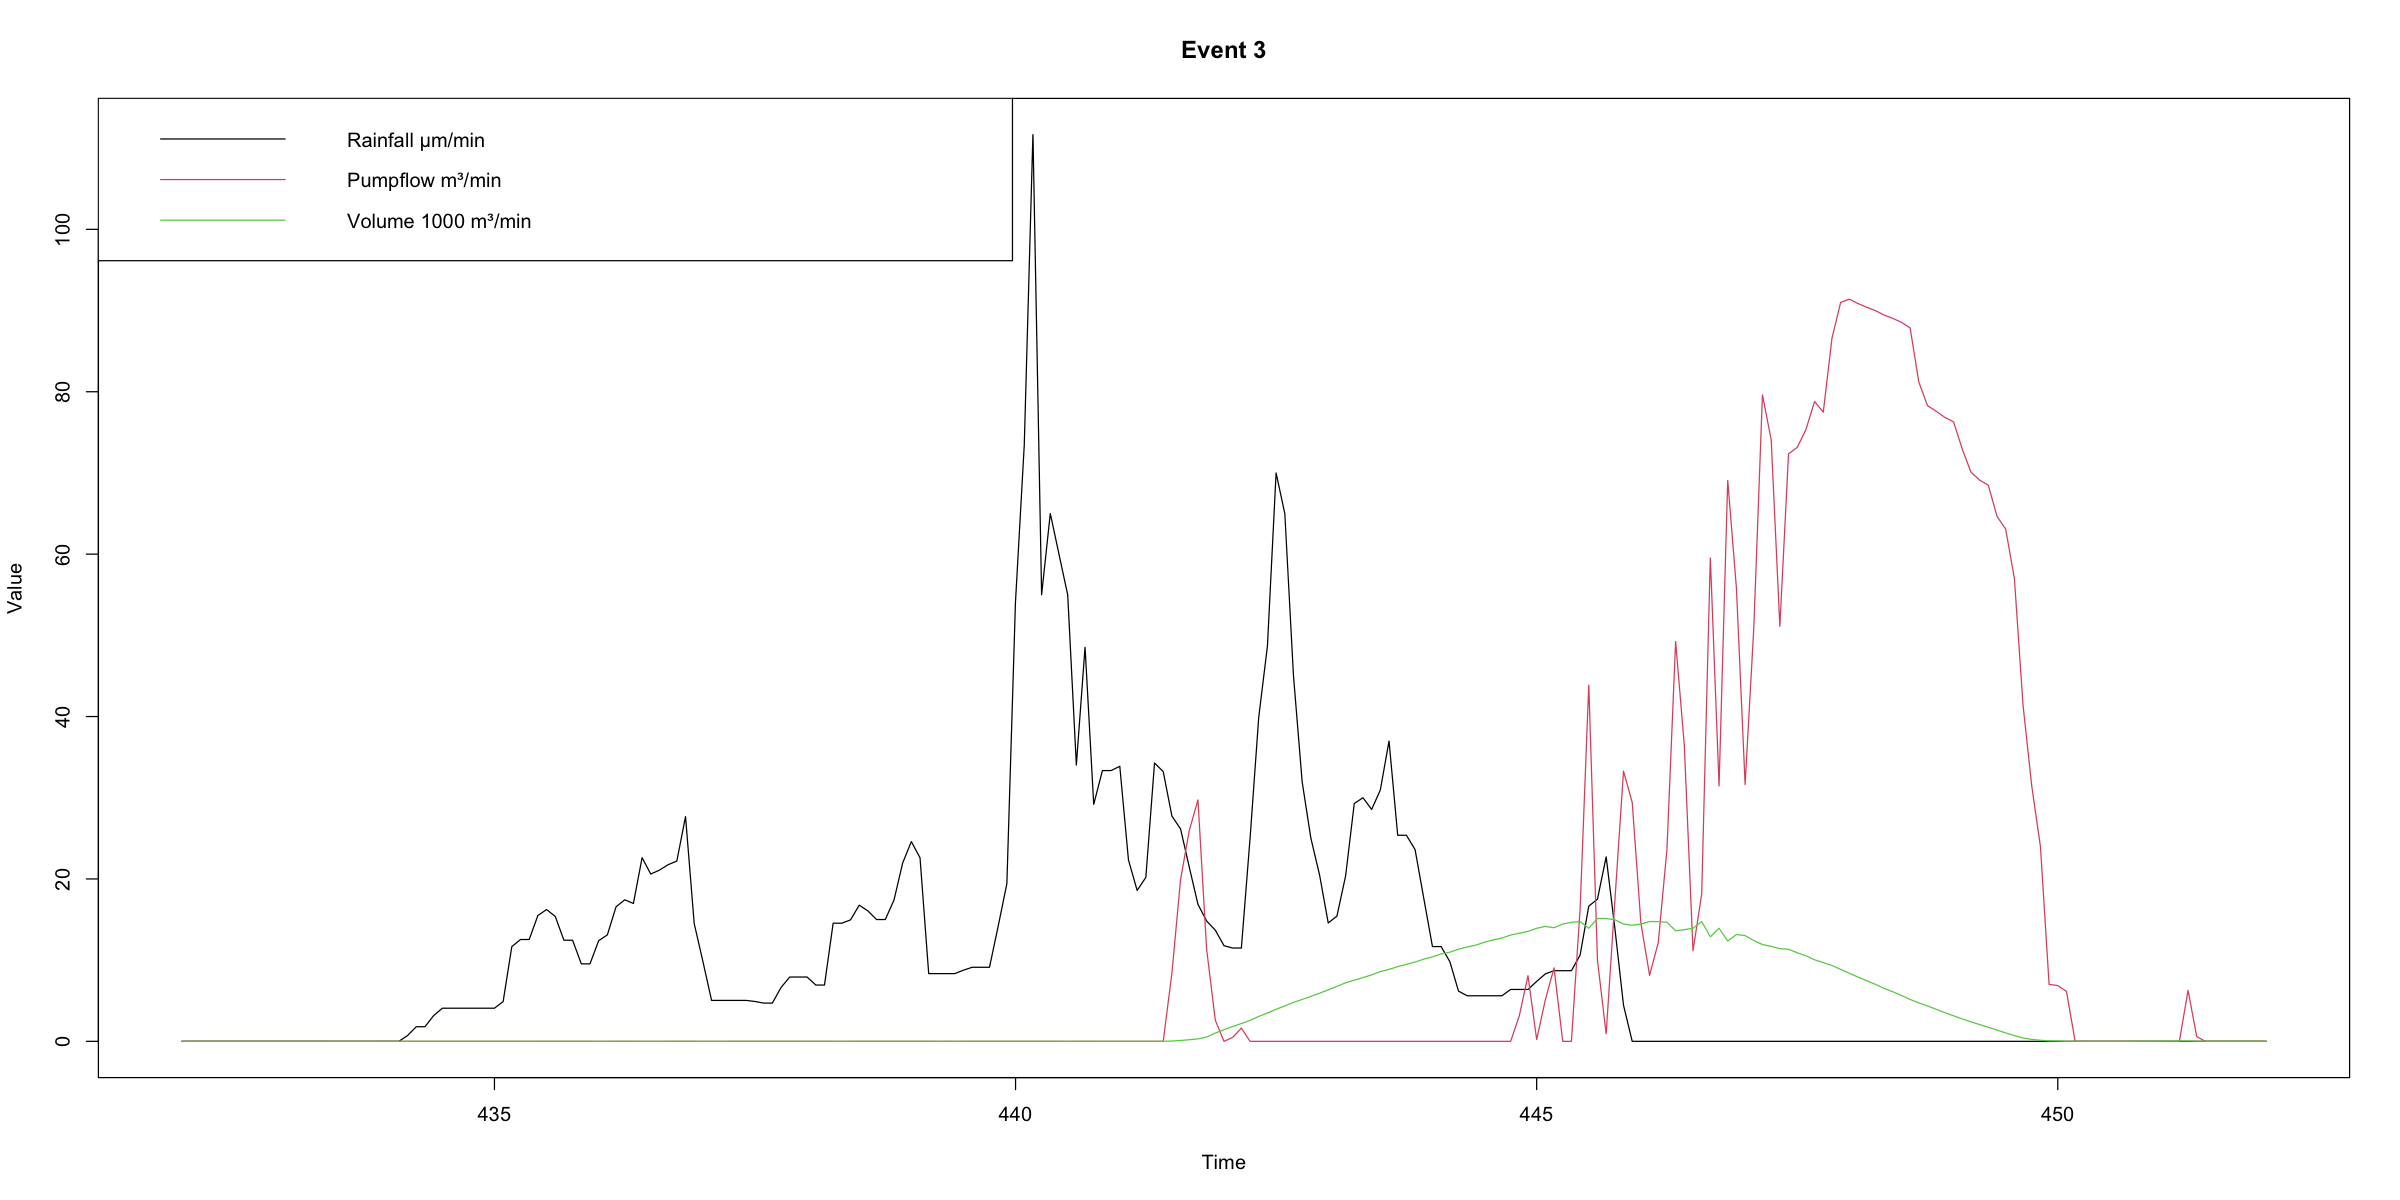

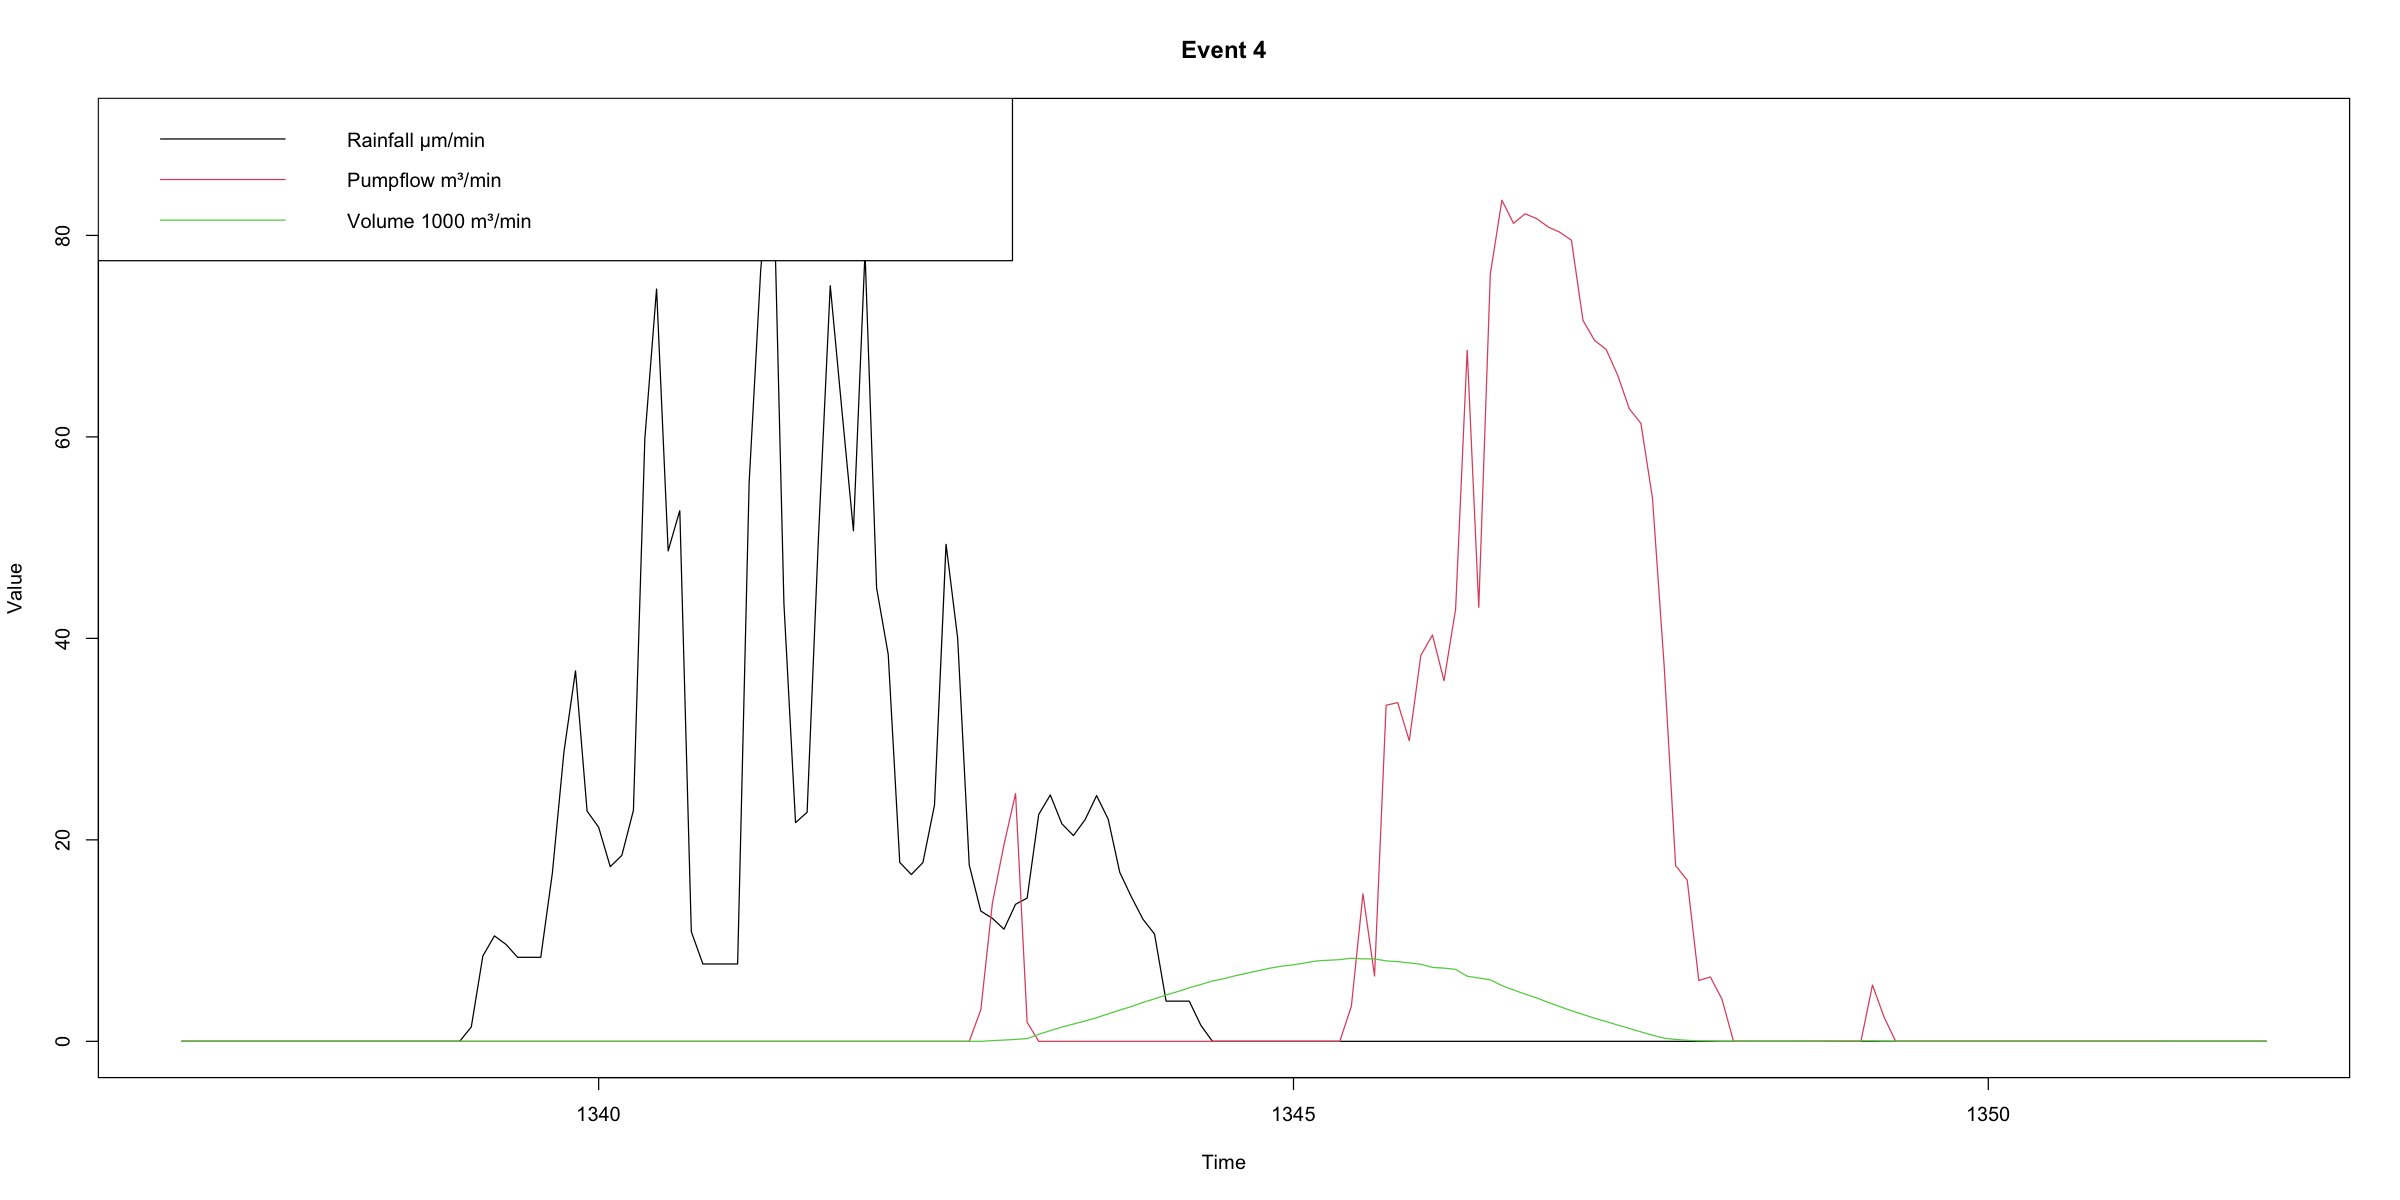

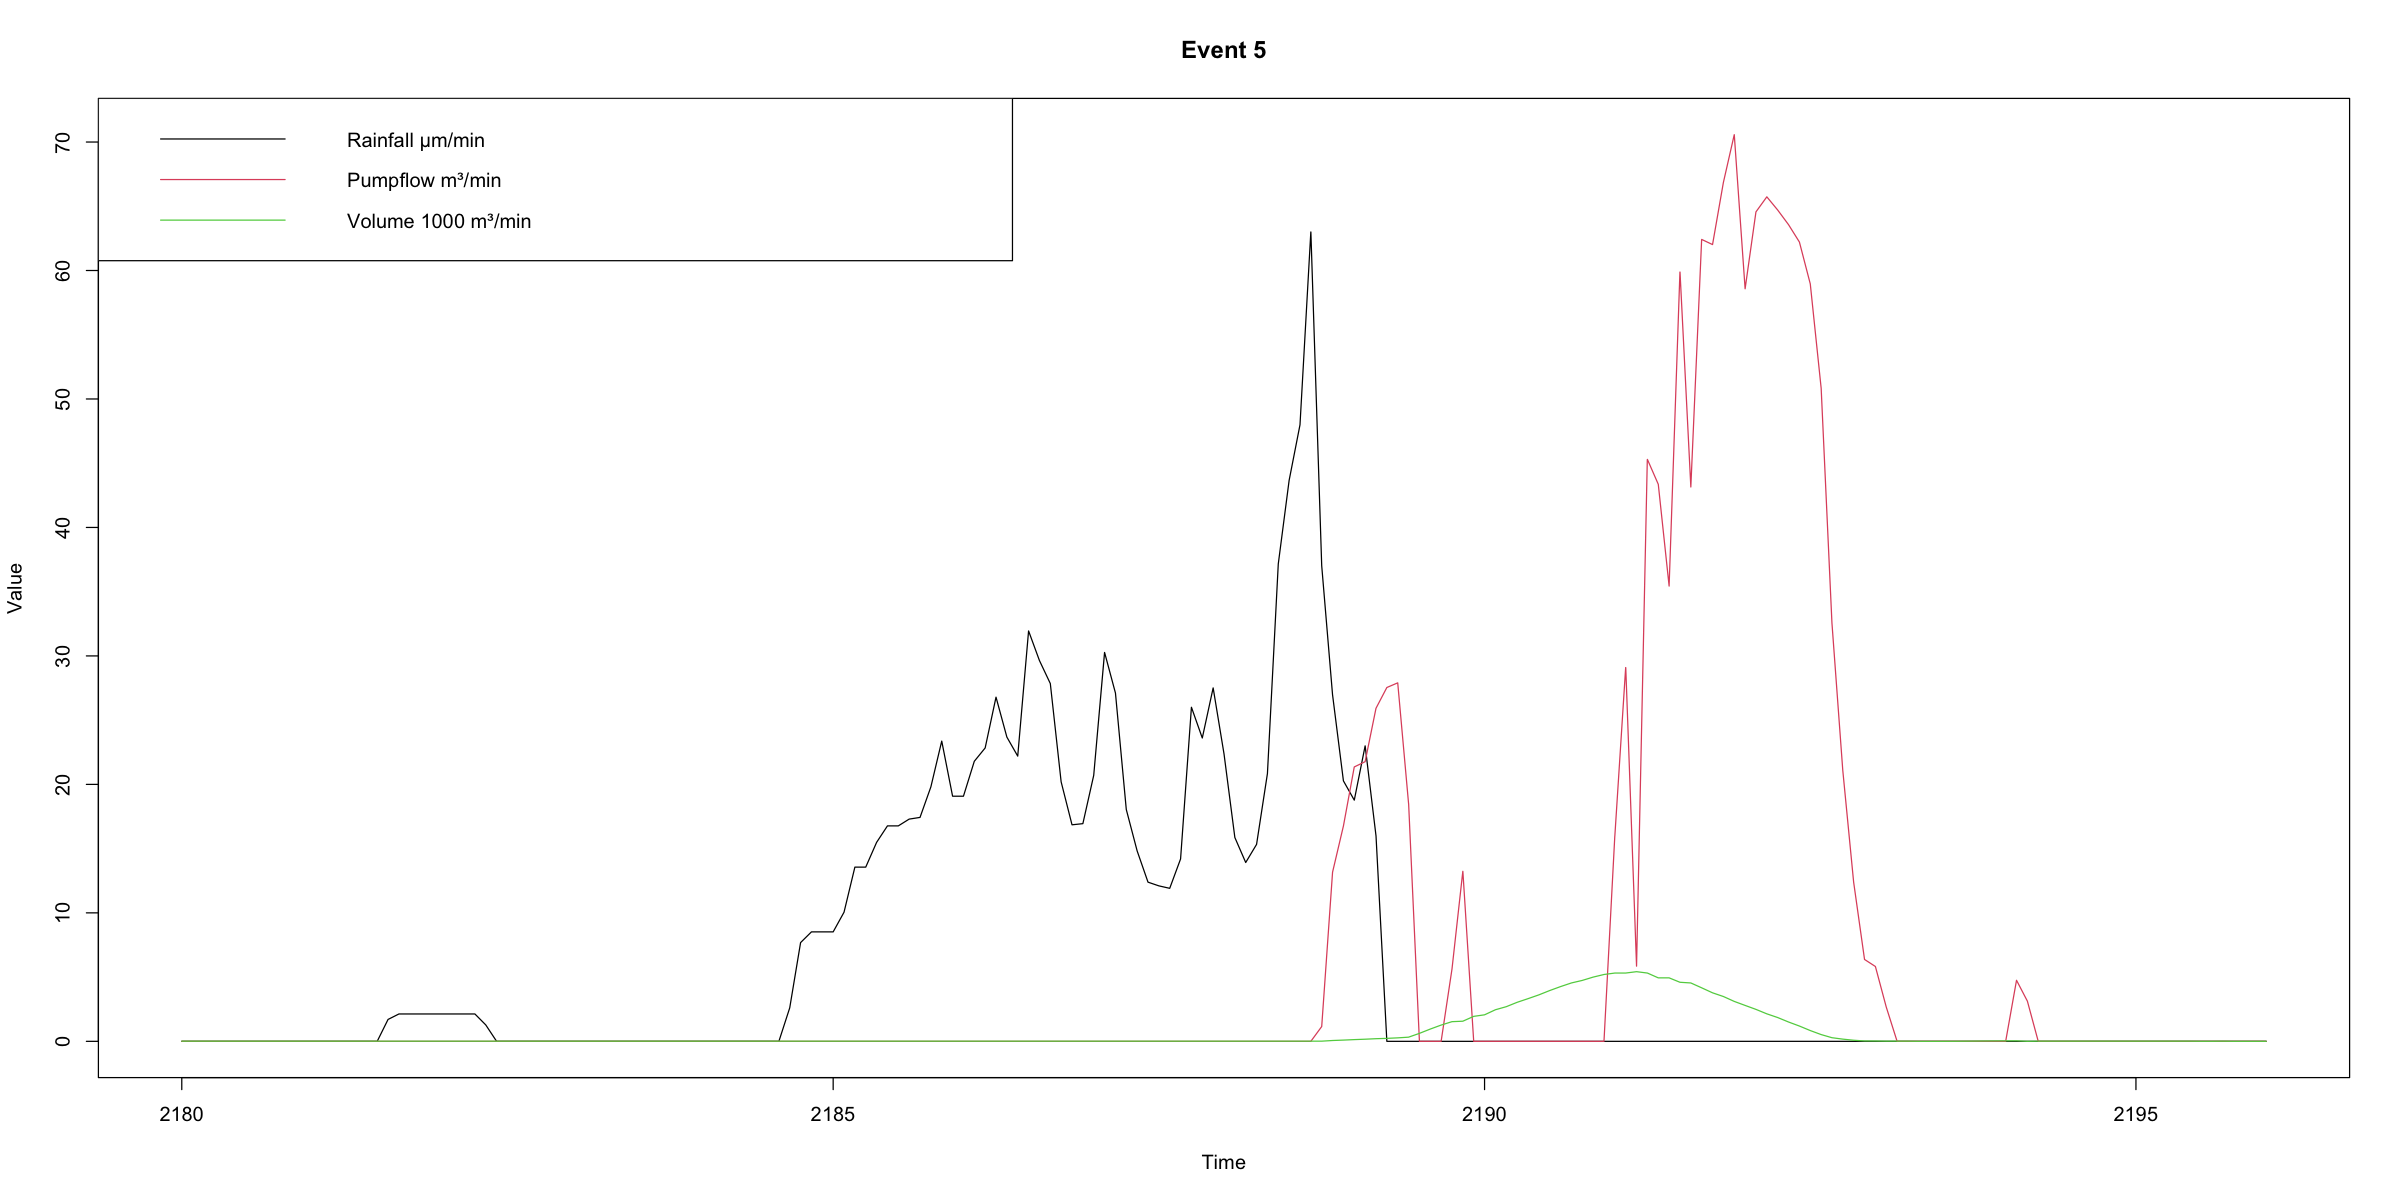

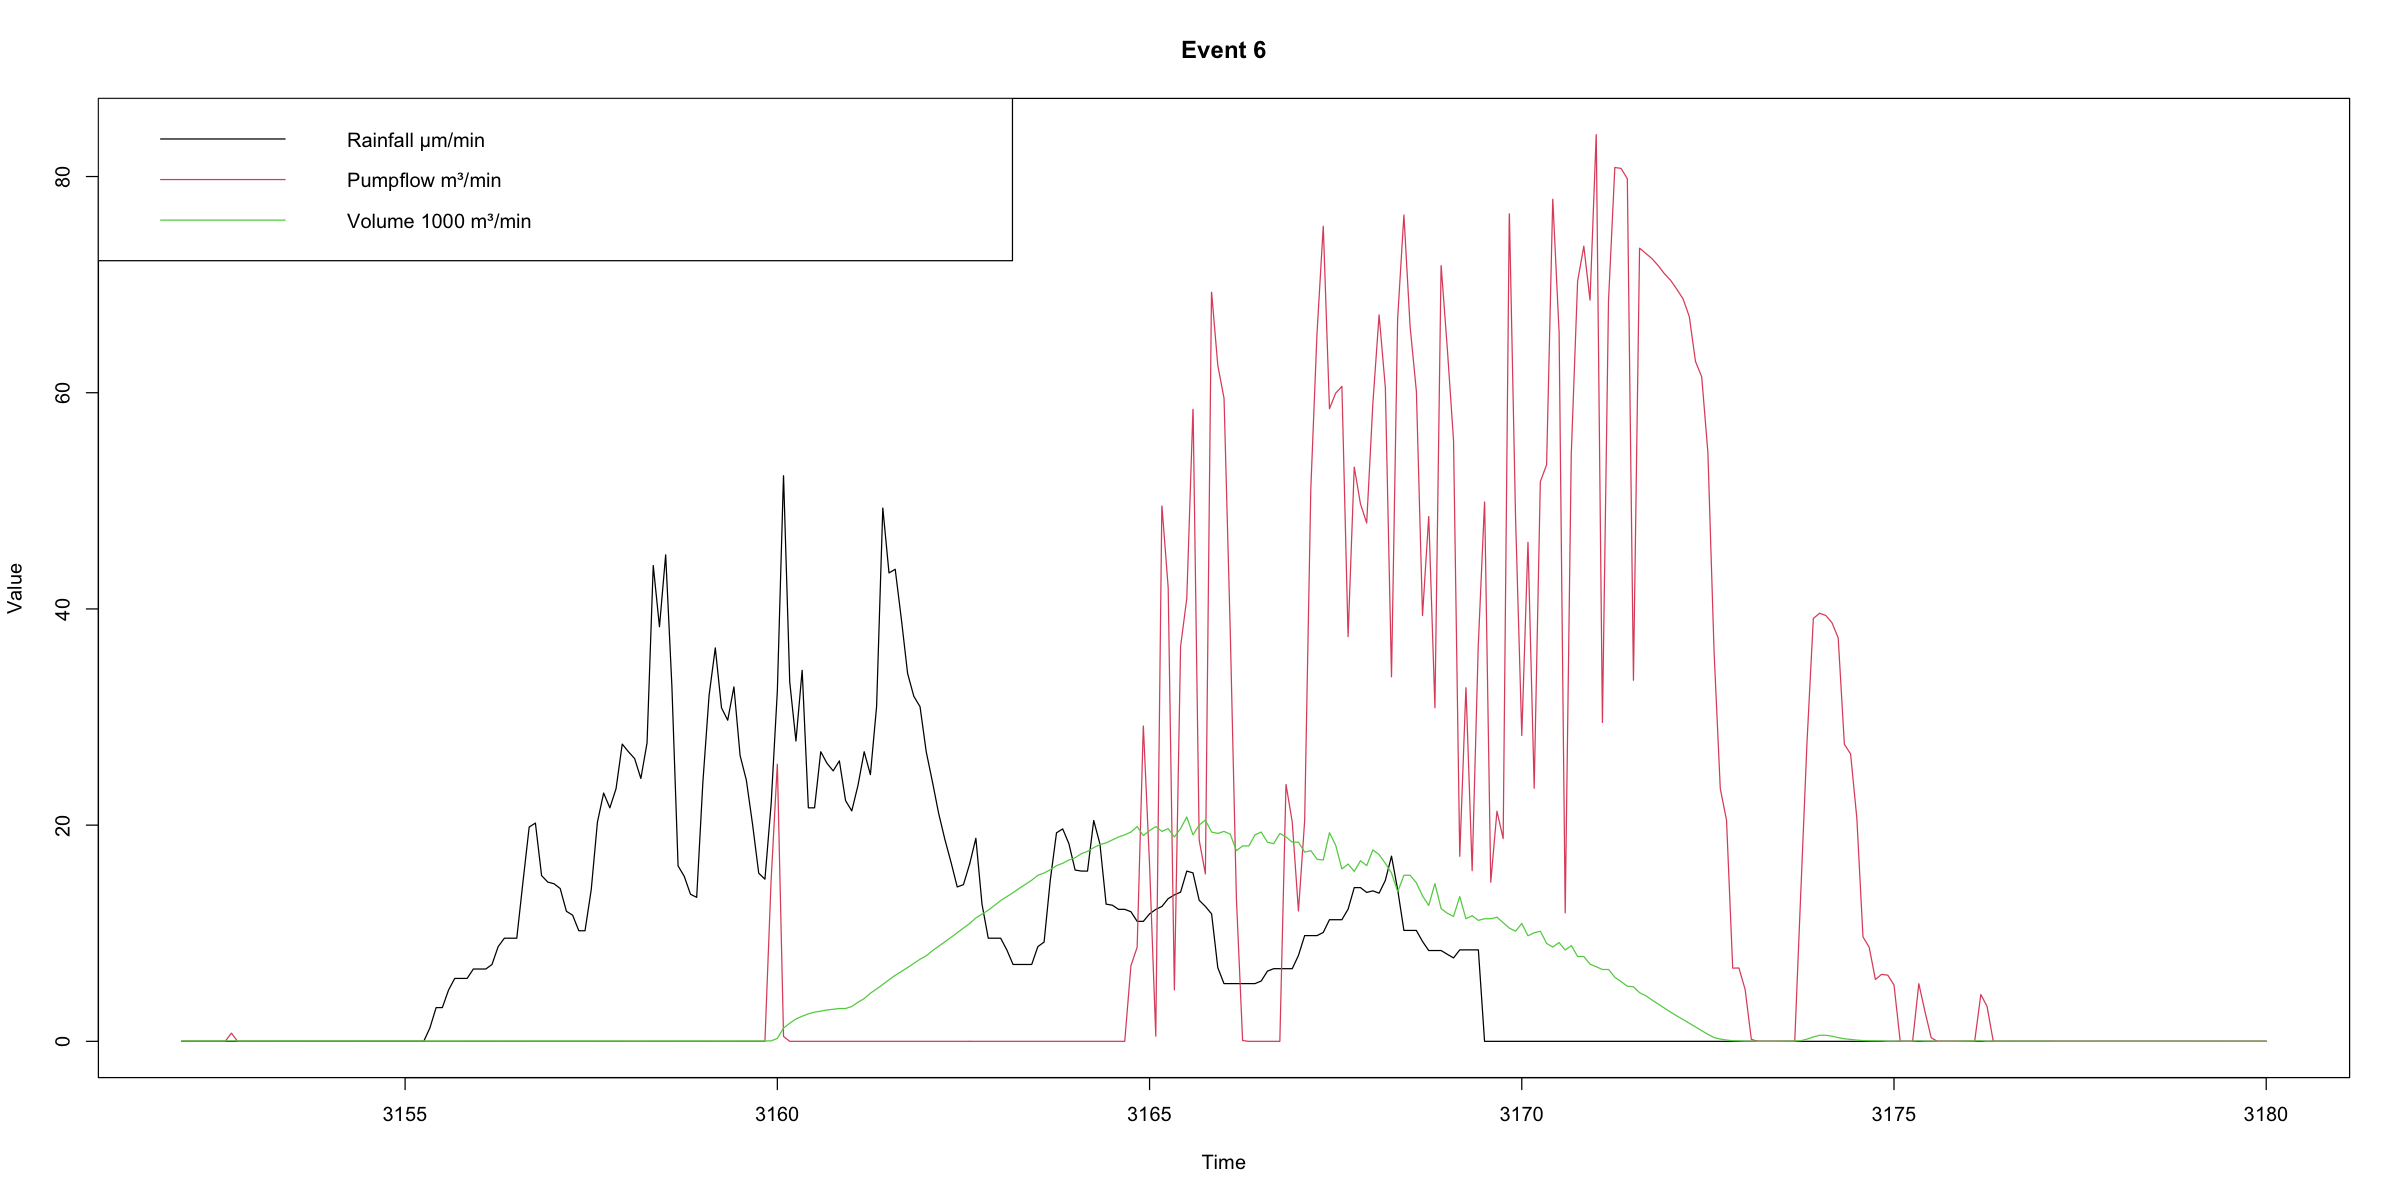

In [ ]:
plot_event(data,1)
plot_event(data,2)
plot_event(data,3)
plot_event(data,4)
plot_event(data,5)
plot_event(data,6)

In [ ]:
Event1 <- data[data$Event_ID == 1, ]

model1 <- ctsmTMB$new()

# SDE system
model1$addSystem(
  dVg  ~ A * Rainfall * (1/1e6) * dt - (1/Kgs) * Vg  * dt + sigma_v * dw1,
  dVs  ~ (1/Kgs) * Vg * dt - (1/Ksd) * Vs * dt -
         (1 / (1 + exp(10 * (Vs - Cs)))) * (-1) * ((1/Kgs) * Vg - (1/Ksd) * Vs) * dt + sigma_v * dw2,
  dVo  ~ (1 / (1 + exp(10 * (Vs - Cs)))) * (-1) * ((1/Kgs) * Vg - (1/Ksd) * Vs) * dt -
         (1/Kot) * Vo * dt + sigma_v * dw3,
  dVt  ~ (1/Kot) * Vo * dt - (1/Ktst) * Vt * dt + sigma_v * dw4,
  dVst ~ (1/Ktst) * Vt * dt - Pumpflow * 60 * dt + sigma_v * dw5
)

# Observation
model1$addObs(Volume ~ Vst)
model1$setVariance(Volume ~ sigma_y^2)

# Inputs
model1$addInput(Rainfall)
model1$addInput(Pumpflow)

# Parameters
model1$setParameter(
  A       = c(initial = 1,   lower = 1e-6, upper = 1e6),
  Kgs     = c(initial = 10,  lower = 1e-6, upper = 1e4),
  Ksd     = c(initial = 10,  lower = 1e-6, upper = 1e4),
  Kot     = c(initial = 10,  lower = 1e-6, upper = 1e4),
  Ktst    = c(initial = 10,  lower = 1e-6, upper = 1e4),
  Cs      = c(initial = 100, lower = 1e-6, upper = 1e8),
  sigma_v = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)

# Initial state (mean + covariance)
model1$setInitialState(list(
  x0 = c(Vg = 0, Vs = 0, Vo = 0, Vt = 0, Vst = 0),
  p0 = diag(5) * 0.1
))

# Now estimate
fit1 <- model1$estimate(Event1)

# And now plotting actually means something
plot(fit1)
summary(fit1)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0: 5.0023403e+09:  1.00000  10.0000  10.0000  10.0000  10.0000  100.000 0.100000 0.100000
 10:     1718643.0:  1.00000  9.93753  9.97840  8.68504  2.28223  100.000  5.23916  3.25779
 20:     373499.80:  1.00000  9.80354  9.94923  6.10928 0.0776528  100.000  10.0000  6.77295
 30:     294949.09: 0.999998  9.40873  9.77881  1.01150 0.0646878  100.000  10.0000  6.82576
 40:     293524.01: 0.999997  9.41181  9.86173  1.06354 0.0670385  100.006  10.0000  6.82582
 50:     293216.06: 0.999997  9.41819  9.88029  1.07089 0.0682662  100.006  10.0000  6.82776
 60:     293127.10: 0.999997  9.41965  9.88027  1.07190 0.0689832  100.006  10.0000  6.82974
 70:     292996.15: 0.999997  9.44015  9.92683  1.07062 0.0686291  99.9912  10.0000  6.83060
 80:     292914.62: 0.999999  9.42157  9.89412  1.07866 0.0669808  99.8564  9.99958  6.83157
 90:     292464.25:  1.00001  9.36694  9.88875  1.09076 0.0687362  98.9692  10.0000  6.83686
100:     290733.32: 0.999760  9.27885  9.89124  1.10551 0.0716976  97.46

	 Optimization finished!:
            Elapsed time: 18.827 seconds.
            The objective value is: 1.973259e+05
            The maximum gradient component is: 2.6e+04
            The convergence message is: relative convergence (4)
            Iterations: 2521
            Evaluations: Fun: 3962 Grad: 2522
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value  Pr(>|t|)    
A       5.1945e+00         NA      NA        NA    
Kgs     2.1072e+01 1.4262e-01  147.75 < 2.2e-16 ***
Ksd     3.5235e+01 3.1423e-01  112.13 < 2.2e-16 ***
Kot     1.8582e+00 7.9356e-03  234.15 < 2.2e-16 ***
Ktst    6.3395e-02 1.9377e-04  327.16 < 2.2e-16 ***
Cs      2.1507e+01 1.0732e-01  200.40 < 2.2e-16 ***
sigma_v 1.0000e+01 1.2053e-02  829.65 < 2.2e-16 ***
sigma_y 1.0000e+01 1.7626e-02  567.34 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




###--- Description of Data ---###
#
# Description:
# Rainfall: The rainfall has jagged peaks, that is to say, it rises and falls suddenly.
#           High rainfall seems to predate high volume.
# Pumpflow: The pumpflow also has jagged peaks, which seem to behave particularly jaggedly
#           at the start of a period of pump activity. They peaks smooth out towards the end
#           of a period of activity. High pumpflow seems to follow high volume.
#   Volume: The volume rises steadily before falling steadily in a fairly even mountain.
#
# Challenges:
# 1) Rainfall and pumpflow behave extremely jaggedly at times- mapping this relatively wild behavior accuratley could be difficult.
# 2) The variables have considerably different magnitudes. As mentioned in the problem statement, it may be necessary to rescale
# 3) A large chunk of the dataset is made of very low values. This could cause "weirdness" during estimation.


#####----- Part 2.3.2 -----#####
# Differential equations:
#     d Vg = A*Rainfall*dt - rgs*Vg*dt + sigma*dw1
#     d Vs = rgs*Vg*dt - rsd*Vs*dt - (1/(1+e^(a*(Vs-Cs))))*(-1)*(rgs*Vg-rsd*Vs)*dt + sigma*dw2
#     d Vo = (1/(1+e^(a*(Vs-Cs))))*(-1)*(rgs*Vg-rsd*Vs)*dt - rot*Vo*dt + sigma*dw3
#     d Vt = rot*Vo*dt - rtst*Vt*dt + sigma*dw4
# d Volume = rtst*Vt*dt - Pumpflow*dt + sigma*dw5
#
# Sates and inputs:
#       Vg: Ground surface volume
#       Vs: Combined sewer volume
#       Vo: Overflow structure volume
#       Vt: Stormwater tunnel volume
#   Volume: Storage tower volume
# Rainfall: Rainfall input
# Pumpflow: Pumpflow rate input
#
# Parameters:
# sigma: standard deviation of the noise
#     A: ground surface area parameter
#     a: sigmoid parameter, higher approaches an indicator function
#    Cs: other sigmoid parameter, represents sewer capacity
#   rgs: rate parameter between ground surface and combined sewer system
#   rsd: rate parameter between combined sewer system and further downstream (exits the model)
#   rot: rate parameter between overflow structue and stormwater tunnel
#  rtst: rate parameter between stormwater tunnel and storage tower
#
# Note that the messy function between the combined sewer system and the overflow structure.
# This is meant to ensure that once the volume of the sewer reaches capacity, the excess inflow is directed to the overflow structure.




#####----- Part 2.3.3 -----#####

###---Data management---###
#
# I want to model in terms of volume in meters cubed per hour (m³/h), so I need to add a scaling parameter:
# The Rainfall is in micrometers per minute, so I divide by 1000000 to get meters per minute (see dVg equation)
# Similarly, the Pumpflow is per minute, so to convert to rate per hour I multiply by 60 (see dVst equation)